In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '0'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as Data
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

from torch.nn.utils import clip_grad_norm_
from torch.distributions.laplace import Laplace

from _utils import clip_generator, add_noise_generator

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedadam'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 1
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 50 #epochs
        self.local_epochs = 10
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform
        self.max_grad_norm = 1.0

        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

group = {'noise_scale':0.03, 'norm_bound':1.5}
# 0 0.01 0.03 0.05 0.07 0.10

In [5]:
sys.path.append('../')
from logdeep.tools.predict_sl_dp import Predicter
from logdeep.tools.train_sl_dp import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = device

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = False
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-2
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "deeplog"
options['save_dir'] = "../result/deeplog/"

# Predict
options['model_path'] = "../result/deeplog/deeplog_last.pth"
options['num_candidates'] = 9

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
# https://github.com/abedicodes/FedSL/blob/master/models/Networks.py
# model改兩個的話，train的部份也要改
# 隨時小心forward 跟 backward有沒有都對上
class deeplog(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, _ = self.lstm(input0, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class deeplog_1st(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog_1st, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, (outpreh, outprec) = self.lstm(input0, (h0, c0))
#         out = self.fc(out[:, -1, :])
        return out, outpreh, outprec


class deeplog_2nd(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog_2nd, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, hPrevious, cPrevious, device):
        input0 = features[0]
#         h0 = torch.zeros(self.num_layers, input0.size(0),
#                          self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, input0.size(0),
#                          self.hidden_size).to(device)
        out, _ = self.lstm(input0,  (hPrevious, cPrevious))
        out = self.fc(out[:, -1, :])
        return out 

# Federated learning

In [7]:
def communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_1.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]
                    server_model_1.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key in server_model_2.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_2.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]
                    server_model_2.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_1[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_1[key] = param.grad
                v_1[key] = v_1[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])                         
            for key, param in server_model_2.named_parameters():
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_2[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_2[key] = param.grad
                v_2[key] = v_2[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key]) 
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():
                clip = clip_generator(norm_bound=group['norm_bound'])
                add_noise = add_noise_generator(noise_scale=group['noise_scale'] * group['norm_bound'])
                
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                         
                param.grad = temp - param.data   
                param.grad = add_noise(clip(param.grad))
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_1[key] = param.grad    
                
                #梯度裁剪
                
                v_1[key] = torch.mul(v_1[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr)
                
#                 big1 = torch.max(param.data)
#                 clip_grad_norm_(param.data, max_norm = big1)
#                 m1 = Laplace(torch.tensor([0.0]).to(device),  torch.tensor([1.0]).to(device)) # scale=sensitivity/epsilon
#                 param.data = torch.add(param.data, m1.sample())
                
                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key, param in server_model_2.named_parameters():       
                clip = clip_generator(norm_bound=group['norm_bound'])
                add_noise = add_noise_generator(noise_scale=group['noise_scale'] * group['norm_bound'])
                
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                         
                param.grad = temp - param.data   
                param.grad = add_noise(clip(param.grad))
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_2[key] = param.grad                
                v_2[key] = torch.mul(v_2[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr)
                
#                 big2 = torch.max(param.data)
#                 clip_grad_norm_(param.data, max_norm = big2)
#                 m2 = Laplace(torch.tensor([0.0]).to(device), torch.tensor([1.0]).to(device)) # scale=sensitivity/epsilon
#                 param.data = torch.add(param.data, m2.sample())
                
                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_1.state_dict()[key].data.copy_(models_1[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_1.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                        
                    server_model_1.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])  
            for key in server_model_2.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_2.state_dict()[key].data.copy_(models_2[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_2.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                        
                    server_model_2.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])  
    return server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2

In [8]:
# # setup model
server_model_1 = deeplog_1st(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
server_model_2 = deeplog_2nd(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)

# for adaptive velocity
v_1 = {}
grad_1 = {}
v_2 = {}
grad_2 = {}

for key in server_model_1.state_dict().keys():
    v_1[key] = torch.add(torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_1[key] = torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32)
for key in server_model_2.state_dict().keys():
    v_2[key] = torch.add(torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_2[key] = torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32)
    

# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models_1 = [copy.deepcopy(server_model_1).to(device) for idx in range(client_num)]
models_2 = [copy.deepcopy(server_model_2).to(device) for idx in range(client_num)]

start_iter = 0

for i in range(args.client_num):
    exec('lloogg_'+str(i+1)+ " = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]},'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}")


result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            trainer = Trainer(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2 = communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2 )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            predicter = Predicter(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 18/5258 [00:00<00:31, 168.23it/s]

sampling...


:   0%|                                                                                        | 0/23 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:35:59 | Learning rate: 0.000313


Train loss: 2.77469:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 49.02it/s]

Starting epoch: 1 | phase: train | ⏰: 01:36:09 | Learning rate: 0.000625


Train loss: 1.87906:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 38.84it/s]

Starting epoch: 2 | phase: train | ⏰: 01:36:09 | Learning rate: 0.001250


Train loss: 1.53862:  26%|████████████████▏                                             | 6/23 [00:00<00:00, 52.17it/s]

Starting epoch: 3 | phase: train | ⏰: 01:36:10 | Learning rate: 0.002500


Train loss: 1.10345:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.62it/s]

Starting epoch: 4 | phase: train | ⏰: 01:36:10 | Learning rate: 0.005000


Train loss: 0.83725:  26%|████████████████▏                                             | 6/23 [00:00<00:00, 54.05it/s]

Starting epoch: 5 | phase: train | ⏰: 01:36:11 | Learning rate: 0.010000


Train loss: 0.55322:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.05it/s]

Starting epoch: 6 | phase: train | ⏰: 01:36:11 | Learning rate: 0.010000


Train loss: 0.45137:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.62it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:36:12 
Validation loss: 0.43038278818130493
Starting epoch: 7 | phase: train | ⏰: 01:36:12 | Learning rate: 0.010000


Train loss: 0.43943:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.74it/s]

Starting epoch: 8 | phase: train | ⏰: 01:36:13 | Learning rate: 0.010000


Train loss: 0.36377:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:36:13 
Validation loss: 0.35550713539123535
Starting epoch: 9 | phase: train | ⏰: 01:36:13 | Learning rate: 0.010000


Train loss: 0.35325: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.00it/s]


============ Test epoch 0 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:11<00:00, 373.49it/s]


false positive (FP): 160390, false negative (FN): 3364, Precision: 7.750%, Recall: 80.021%, F1-measure: 14.131%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 71.282
Finished Predicting
elapsed_time: 49.68799424171448
============ Train epoch 1 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 21/5258 [00:00<00:26, 198.11it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 179.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


:   0%|                                                                                        | 0/23 [00:00<?, ?it/s]

Starting epoch: 0 | phase: train | ⏰: 01:38:29 | Learning rate: 0.000313


Train loss: 2.20198:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.45it/s]

Starting epoch: 1 | phase: train | ⏰: 01:38:31 | Learning rate: 0.000625


Train loss: 1.52236:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 2 | phase: train | ⏰: 01:38:32 | Learning rate: 0.001250


Train loss: 0.99756:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 38.17it/s]

Starting epoch: 3 | phase: train | ⏰: 01:38:32 | Learning rate: 0.002500


Train loss: 0.93401:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.62it/s]

Starting epoch: 4 | phase: train | ⏰: 01:38:33 | Learning rate: 0.005000


Train loss: 0.57554:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 5 | phase: train | ⏰: 01:38:33 | Learning rate: 0.010000


Train loss: 0.45855:  26%|████████████████▏                                             | 6/23 [00:00<00:00, 50.42it/s]

Starting epoch: 6 | phase: train | ⏰: 01:38:34 | Learning rate: 0.010000


Train loss: 0.43677:   0%|                                                                      | 0/23 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:38:34 
Validation loss: 0.4416523079077403
Starting epoch: 7 | phase: train | ⏰: 01:38:35 | Learning rate: 0.010000


Train loss: 0.37919:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 8 | phase: train | ⏰: 01:38:35 | Learning rate: 0.010000


Train loss: 0.38394:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:38:36 
Validation loss: 0.35669517517089844
Starting epoch: 9 | phase: train | ⏰: 01:38:36 | Learning rate: 0.010000


Train loss: 0.41140: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.64it/s]


============ Test epoch 1 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:15<00:00, 263.13it/s]


false positive (FP): 159949, false negative (FN): 342, Precision: 9.349%, Recall: 97.969%, F1-measure: 17.069%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 71.889
Finished Predicting
elapsed_time: 55.10333776473999
============ Train epoch 2 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575
sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 176.99it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 2.47806:  13%|████████                                                      | 3/23 [00:00<00:00, 26.09it/s]

Starting epoch: 0 | phase: train | ⏰: 01:40:55 | Learning rate: 0.000313


Train loss: 1.51051:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 1 | phase: train | ⏰: 01:40:55 | Learning rate: 0.000625


Train loss: 0.89746:  26%|████████████████▏                                             | 6/23 [00:00<00:00, 48.39it/s]

Starting epoch: 2 | phase: train | ⏰: 01:40:56 | Learning rate: 0.001250


Train loss: 0.61267:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 37.04it/s]

Starting epoch: 3 | phase: train | ⏰: 01:40:56 | Learning rate: 0.002500


Train loss: 0.55341:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 48.54it/s]

Starting epoch: 4 | phase: train | ⏰: 01:40:57 | Learning rate: 0.005000


Train loss: 0.44969:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.05it/s]

Starting epoch: 5 | phase: train | ⏰: 01:40:57 | Learning rate: 0.010000


Train loss: 0.39422:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 6 | phase: train | ⏰: 01:40:58 | Learning rate: 0.010000


Train loss: 0.34057:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.06it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:40:58 
Validation loss: 0.3478781183560689
Starting epoch: 7 | phase: train | ⏰: 01:40:58 | Learning rate: 0.010000


Train loss: 0.38589:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 48.08it/s]

Starting epoch: 8 | phase: train | ⏰: 01:40:59 | Learning rate: 0.010000


Train loss: 0.31498:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.48it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:40:59 
Validation loss: 0.3247678279876709
Starting epoch: 9 | phase: train | ⏰: 01:40:59 | Learning rate: 0.010000


Train loss: 0.30894: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.20it/s]


============ Test epoch 2 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:27<00:00, 149.35it/s]


false positive (FP): 160323, false negative (FN): 157, Precision: 9.424%, Recall: 99.068%, F1-measure: 17.211%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 71.856
Finished Predicting
elapsed_time: 116.15798568725586
============ Train epoch 3 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 24/5258 [00:00<00:22, 233.01it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 174.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.89812:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.04it/s]

Starting epoch: 0 | phase: train | ⏰: 01:44:22 | Learning rate: 0.000313


Train loss: 0.99578:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 1 | phase: train | ⏰: 01:44:23 | Learning rate: 0.000625


Train loss: 0.64863:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 2 | phase: train | ⏰: 01:44:23 | Learning rate: 0.001250


Train loss: 0.48744:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 33.56it/s]

Starting epoch: 3 | phase: train | ⏰: 01:44:24 | Learning rate: 0.002500


Train loss: 0.46199:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 37.38it/s]

Starting epoch: 4 | phase: train | ⏰: 01:44:24 | Learning rate: 0.005000


Train loss: 0.40557:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.02it/s]

Starting epoch: 5 | phase: train | ⏰: 01:44:25 | Learning rate: 0.010000


Train loss: 0.35542:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 6 | phase: train | ⏰: 01:44:25 | Learning rate: 0.010000


Train loss: 0.32365:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:44:26 
Validation loss: 0.3044190506140391
Starting epoch: 7 | phase: train | ⏰: 01:44:26 | Learning rate: 0.010000


Train loss: 0.29058:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 40.00it/s]

Starting epoch: 8 | phase: train | ⏰: 01:44:27 | Learning rate: 0.010000


Train loss: 0.48469:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.79it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:44:27 
Validation loss: 0.40905990203221637
Starting epoch: 9 | phase: train | ⏰: 01:44:27 | Learning rate: 0.010000


Train loss: 0.42074: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.52it/s]


============ Test epoch 3 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:23<00:00, 174.76it/s]


false positive (FP): 47980, false negative (FN): 110, Precision: 25.852%, Recall: 99.347%, F1-measure: 41.027%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 91.566
Finished Predicting
elapsed_time: 171.30898022651672
============ Train epoch 4 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 36/5258 [00:00<00:29, 176.83it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 175.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.36515:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 48.54it/s]

Starting epoch: 0 | phase: train | ⏰: 01:48:44 | Learning rate: 0.000313


Train loss: 0.70351:  26%|████████████████▏                                             | 6/23 [00:00<00:00, 48.39it/s]

Starting epoch: 1 | phase: train | ⏰: 01:48:44 | Learning rate: 0.000625


Train loss: 0.51272:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 49.02it/s]

Starting epoch: 2 | phase: train | ⏰: 01:48:45 | Learning rate: 0.001250


Train loss: 0.41964:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 33.56it/s]

Starting epoch: 3 | phase: train | ⏰: 01:48:45 | Learning rate: 0.002500


Train loss: 0.36817:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 4 | phase: train | ⏰: 01:48:46 | Learning rate: 0.005000


Train loss: 0.50249:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 48.54it/s]

Starting epoch: 5 | phase: train | ⏰: 01:48:47 | Learning rate: 0.010000


Train loss: 0.34903:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 6 | phase: train | ⏰: 01:48:47 | Learning rate: 0.010000


Train loss: 0.31222:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:48:48 
Validation loss: 0.3070416947205861
Starting epoch: 7 | phase: train | ⏰: 01:48:48 | Learning rate: 0.010000


Train loss: 0.27970:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 8 | phase: train | ⏰: 01:48:48 | Learning rate: 0.010000


Train loss: 0.25482:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:48:49 
Validation loss: 0.2488990525404612
Starting epoch: 9 | phase: train | ⏰: 01:48:49 | Learning rate: 0.010000


Train loss: 0.27138: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.49it/s]


============ Test epoch 4 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:21<00:00, 193.40it/s]


false positive (FP): 24330, false negative (FN): 128, Precision: 40.716%, Recall: 99.240%, F1-measure: 57.742%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 95.711
Finished Predicting
elapsed_time: 263.7999687194824
============ Train epoch 5 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 36/5258 [00:00<00:29, 174.46it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 175.00it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.15272:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.32it/s]

Starting epoch: 0 | phase: train | ⏰: 01:54:40 | Learning rate: 0.000313


Train loss: 0.54881:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.45it/s]

Starting epoch: 1 | phase: train | ⏰: 01:54:40 | Learning rate: 0.000625


Train loss: 0.42286:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.45it/s]

Starting epoch: 2 | phase: train | ⏰: 01:54:41 | Learning rate: 0.001250


Train loss: 0.36858:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 33.56it/s]

Starting epoch: 3 | phase: train | ⏰: 01:54:41 | Learning rate: 0.002500


Train loss: 0.33277:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 4 | phase: train | ⏰: 01:54:42 | Learning rate: 0.005000


Train loss: 0.40278:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 5 | phase: train | ⏰: 01:54:42 | Learning rate: 0.010000


Train loss: 0.31183:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.62it/s]

Starting epoch: 6 | phase: train | ⏰: 01:54:43 | Learning rate: 0.010000


Train loss: 0.28043:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:54:44 
Validation loss: 0.2629784246285756
Starting epoch: 7 | phase: train | ⏰: 01:54:44 | Learning rate: 0.010000


Train loss: 0.25041:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.73it/s]

Starting epoch: 8 | phase: train | ⏰: 01:54:44 | Learning rate: 0.010000


Train loss: 0.24003:  13%|████████                                                      | 3/23 [00:00<00:00, 29.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:54:45 
Validation loss: 0.2316876401503881
Starting epoch: 9 | phase: train | ⏰: 01:54:45 | Learning rate: 0.010000


Train loss: 0.24555: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.85it/s]


============ Test epoch 5 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:51<00:00, 79.83it/s]


false positive (FP): 3236, false negative (FN): 135, Precision: 83.771%, Recall: 99.198%, F1-measure: 90.834%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.409
Finished Predicting
elapsed_time: 378.5709183216095
============ Train epoch 6 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 17/5258 [00:00<00:30, 170.00it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 172.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 0.93331:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.05it/s]

Starting epoch: 0 | phase: train | ⏰: 02:02:30 | Learning rate: 0.000313


Train loss: 0.49009:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 1 | phase: train | ⏰: 02:02:31 | Learning rate: 0.000625


Train loss: 0.38496:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 49.02it/s]

Starting epoch: 2 | phase: train | ⏰: 02:02:31 | Learning rate: 0.001250


Train loss: 0.32273:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 37.31it/s]

Starting epoch: 3 | phase: train | ⏰: 02:02:32 | Learning rate: 0.002500


Train loss: 0.28524:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 4 | phase: train | ⏰: 02:02:32 | Learning rate: 0.005000


Train loss: 0.37625:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 49.02it/s]

Starting epoch: 5 | phase: train | ⏰: 02:02:33 | Learning rate: 0.010000


Train loss: 0.29338:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 6 | phase: train | ⏰: 02:02:33 | Learning rate: 0.010000


Train loss: 0.24730:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:02:34 
Validation loss: 0.25809457898139954
Starting epoch: 7 | phase: train | ⏰: 02:02:34 | Learning rate: 0.010000


Train loss: 0.23512:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 8 | phase: train | ⏰: 02:02:35 | Learning rate: 0.010000


Train loss: 0.23472:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:02:35 
Validation loss: 0.23355053861935934
Starting epoch: 9 | phase: train | ⏰: 02:02:35 | Learning rate: 0.010000


Train loss: 0.23177: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.12it/s]


============ Test epoch 6 ============
Client  0


  0%|                                                                                | 8/14177 [00:00<03:25, 68.95it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:51<00:00, 79.65it/s]


false positive (FP): 3164, false negative (FN): 150, Precision: 84.062%, Recall: 99.109%, F1-measure: 90.968%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.419
Finished Predicting
elapsed_time: 268.12697100639343
============ Train epoch 7 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|                                                                                         | 0/5258 [00:00<?, ?it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 175.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 0.68393:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 40.98it/s]

Starting epoch: 0 | phase: train | ⏰: 02:08:30 | Learning rate: 0.000313


Train loss: 0.40884:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.73it/s]

Starting epoch: 1 | phase: train | ⏰: 02:08:31 | Learning rate: 0.000625


Train loss: 0.34174:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.74it/s]

Starting epoch: 2 | phase: train | ⏰: 02:08:31 | Learning rate: 0.001250


Train loss: 0.29627:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 35.21it/s]

Starting epoch: 3 | phase: train | ⏰: 02:08:32 | Learning rate: 0.002500


Train loss: 0.26463:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 4 | phase: train | ⏰: 02:08:32 | Learning rate: 0.005000


Train loss: 0.46262:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.45it/s]

Starting epoch: 5 | phase: train | ⏰: 02:08:33 | Learning rate: 0.010000


Train loss: 0.34505:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 6 | phase: train | ⏰: 02:08:34 | Learning rate: 0.010000


Train loss: 0.27604:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.78it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:08:34 
Validation loss: 0.2899085581302643
Starting epoch: 7 | phase: train | ⏰: 02:08:34 | Learning rate: 0.010000


Train loss: 0.25180:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.22it/s]

Starting epoch: 8 | phase: train | ⏰: 02:08:35 | Learning rate: 0.010000


Train loss: 0.25918:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 35.40it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:08:35 
Validation loss: 0.2542944351832072
Starting epoch: 9 | phase: train | ⏰: 02:08:35 | Learning rate: 0.010000


Train loss: 0.24849: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.71it/s]


============ Test epoch 7 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:55<00:00, 74.36it/s]


false positive (FP): 2320, false negative (FN): 417, Precision: 87.621%, Recall: 97.523%, F1-measure: 92.307%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.520
Finished Predicting
elapsed_time: 384.4591884613037
============ Train epoch 8 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 20/5258 [00:00<00:26, 196.08it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 178.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 0.77573:  13%|████████                                                      | 3/23 [00:00<00:01, 19.35it/s]

Starting epoch: 0 | phase: train | ⏰: 02:16:24 | Learning rate: 0.000313


Train loss: 0.37580:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 49.02it/s]

Starting epoch: 1 | phase: train | ⏰: 02:16:25 | Learning rate: 0.000625


Train loss: 0.30448:  26%|████████████████▏                                             | 6/23 [00:00<00:00, 52.17it/s]

Starting epoch: 2 | phase: train | ⏰: 02:16:25 | Learning rate: 0.001250


Train loss: 0.26398:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 40.65it/s]

Starting epoch: 3 | phase: train | ⏰: 02:16:26 | Learning rate: 0.002500


Train loss: 0.25517:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 4 | phase: train | ⏰: 02:16:26 | Learning rate: 0.005000


Train loss: 0.24605:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 48.08it/s]

Starting epoch: 5 | phase: train | ⏰: 02:16:27 | Learning rate: 0.010000


Train loss: 0.26375:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 6 | phase: train | ⏰: 02:16:27 | Learning rate: 0.010000


Train loss: 0.24661:  13%|████████                                                      | 3/23 [00:00<00:00, 29.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:16:28 
Validation loss: 0.2503453195095062
Starting epoch: 7 | phase: train | ⏰: 02:16:28 | Learning rate: 0.010000


Train loss: 0.23022:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 8 | phase: train | ⏰: 02:16:29 | Learning rate: 0.010000


Train loss: 0.22139:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:16:29 
Validation loss: 0.2417739282051722
Starting epoch: 9 | phase: train | ⏰: 02:16:29 | Learning rate: 0.010000


Train loss: 0.22180: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.14it/s]


============ Test epoch 8 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:00<00:00, 68.20it/s]


false positive (FP): 2294, false negative (FN): 372, Precision: 87.772%, Recall: 97.791%, F1-measure: 92.511%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.532
Finished Predicting
elapsed_time: 342.2559893131256
============ Train epoch 9 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 36/5258 [00:00<00:29, 177.49it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 177.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 0.68026:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 0 | phase: train | ⏰: 02:23:39 | Learning rate: 0.000313


Train loss: 0.37640:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.62it/s]

Starting epoch: 1 | phase: train | ⏰: 02:23:39 | Learning rate: 0.000625


Train loss: 0.29561:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 2 | phase: train | ⏰: 02:23:40 | Learning rate: 0.001250


Train loss: 0.25951:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 35.71it/s]

Starting epoch: 3 | phase: train | ⏰: 02:23:40 | Learning rate: 0.002500


Train loss: 0.24056:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 4 | phase: train | ⏰: 02:23:41 | Learning rate: 0.005000


Train loss: 0.24079:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.62it/s]

Starting epoch: 5 | phase: train | ⏰: 02:23:41 | Learning rate: 0.010000


Train loss: 0.22914:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 49.50it/s]

Starting epoch: 6 | phase: train | ⏰: 02:23:42 | Learning rate: 0.010000


Train loss: 0.23211:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 35.40it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:23:43 
Validation loss: 0.23207678397496542
Starting epoch: 7 | phase: train | ⏰: 02:23:43 | Learning rate: 0.010000


Train loss: 0.22437:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 8 | phase: train | ⏰: 02:23:43 | Learning rate: 0.010000


Train loss: 0.21582:  13%|████████                                                      | 3/23 [00:00<00:00, 29.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:23:44 
Validation loss: 0.22144966820875803
Starting epoch: 9 | phase: train | ⏰: 02:23:44 | Learning rate: 0.010000


Train loss: 0.25256: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.67it/s]


============ Test epoch 9 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:25<00:00, 159.53it/s]


false positive (FP): 2830, false negative (FN): 192, Precision: 85.469%, Recall: 98.860%, F1-measure: 91.678%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.470
Finished Predicting
elapsed_time: 332.41200065612793
============ Train epoch 10 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▍                                                                              | 25/5258 [00:00<00:23, 227.27it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 179.89it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 0.66187:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 0 | phase: train | ⏰: 02:30:42 | Learning rate: 0.000313


Train loss: 0.39164:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 1 | phase: train | ⏰: 02:30:42 | Learning rate: 0.000625


Train loss: 0.29501:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.05it/s]

Starting epoch: 2 | phase: train | ⏰: 02:30:43 | Learning rate: 0.001250


Train loss: 0.26198:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 35.21it/s]

Starting epoch: 3 | phase: train | ⏰: 02:30:43 | Learning rate: 0.002500


Train loss: 0.24062:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.02it/s]

Starting epoch: 4 | phase: train | ⏰: 02:30:44 | Learning rate: 0.005000


Train loss: 0.23271:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 5 | phase: train | ⏰: 02:30:45 | Learning rate: 0.010000


Train loss: 0.23229:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 6 | phase: train | ⏰: 02:30:45 | Learning rate: 0.010000


Train loss: 0.23451:  13%|████████                                                      | 3/23 [00:00<00:00, 28.30it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:30:46 
Validation loss: 0.23972413937250772
Starting epoch: 7 | phase: train | ⏰: 02:30:46 | Learning rate: 0.010000


Train loss: 0.21179:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 8 | phase: train | ⏰: 02:30:46 | Learning rate: 0.010000


Train loss: 0.20303:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.79it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:30:47 
Validation loss: 0.21605688333511353
Starting epoch: 9 | phase: train | ⏰: 02:30:47 | Learning rate: 0.010000


Train loss: 0.21248: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.52it/s]


============ Test epoch 10 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:59<00:00, 69.50it/s]


false positive (FP): 2727, false negative (FN): 136, Precision: 85.964%, Recall: 99.192%, F1-measure: 92.106%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.498
Finished Predicting
elapsed_time: 386.6059594154358
============ Train epoch 11 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 22/5258 [00:00<00:24, 209.52it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 175.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 0.76416:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 0 | phase: train | ⏰: 02:38:38 | Learning rate: 0.000313


Train loss: 0.42547:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 1 | phase: train | ⏰: 02:38:39 | Learning rate: 0.000625


Train loss: 0.30624:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 2 | phase: train | ⏰: 02:38:39 | Learning rate: 0.001250


Train loss: 0.26327:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 35.21it/s]

Starting epoch: 3 | phase: train | ⏰: 02:38:40 | Learning rate: 0.002500


Train loss: 0.23896:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 4 | phase: train | ⏰: 02:38:40 | Learning rate: 0.005000


Train loss: 0.23167:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.45it/s]

Starting epoch: 5 | phase: train | ⏰: 02:38:41 | Learning rate: 0.010000


Train loss: 0.22023:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 6 | phase: train | ⏰: 02:38:41 | Learning rate: 0.010000


Train loss: 0.21792:  13%|████████                                                      | 3/23 [00:00<00:00, 28.57it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:38:42 
Validation loss: 0.22071252266565958
Starting epoch: 7 | phase: train | ⏰: 02:38:42 | Learning rate: 0.010000


Train loss: 0.21662:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 8 | phase: train | ⏰: 02:38:42 | Learning rate: 0.010000


Train loss: 0.20984:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:38:43 
Validation loss: 0.21809515357017517
Starting epoch: 9 | phase: train | ⏰: 02:38:43 | Learning rate: 0.010000


Train loss: 0.21061: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.78it/s]


============ Test epoch 11 ============
Client  0


  0%|                                                                                | 8/14177 [00:00<03:27, 68.38it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:54<00:00, 75.06it/s]


false positive (FP): 3666, false negative (FN): 121, Precision: 82.014%, Recall: 99.281%, F1-measure: 89.826%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.336
Finished Predicting
elapsed_time: 271.17397260665894
============ Train epoch 12 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 37/5258 [00:00<00:31, 166.60it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 174.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 0.82783:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.46it/s]

Starting epoch: 0 | phase: train | ⏰: 02:44:39 | Learning rate: 0.000313


Train loss: 0.38152:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 1 | phase: train | ⏰: 02:44:40 | Learning rate: 0.000625


Train loss: 0.28268:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.02it/s]

Starting epoch: 2 | phase: train | ⏰: 02:44:40 | Learning rate: 0.001250


Train loss: 0.24351:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 36.23it/s]

Starting epoch: 3 | phase: train | ⏰: 02:44:41 | Learning rate: 0.002500


Train loss: 0.22784:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.10it/s]

Starting epoch: 4 | phase: train | ⏰: 02:44:41 | Learning rate: 0.005000


Train loss: 0.22972:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 5 | phase: train | ⏰: 02:44:42 | Learning rate: 0.010000


Train loss: 0.22214:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 6 | phase: train | ⏰: 02:44:42 | Learning rate: 0.010000


Train loss: 0.21508:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:44:43 
Validation loss: 0.22208895782629648
Starting epoch: 7 | phase: train | ⏰: 02:44:43 | Learning rate: 0.010000


Train loss: 0.20527:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 49.02it/s]

Starting epoch: 8 | phase: train | ⏰: 02:44:44 | Learning rate: 0.010000


Train loss: 0.20651:  13%|████████                                                      | 3/23 [00:00<00:00, 28.57it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:44:44 
Validation loss: 0.2180347591638565
Starting epoch: 9 | phase: train | ⏰: 02:44:44 | Learning rate: 0.010000


Train loss: 0.20710: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.28it/s]


============ Test epoch 12 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:57<00:00, 71.23it/s]


false positive (FP): 9414, false negative (FN): 97, Precision: 64.007%, Recall: 99.424%, F1-measure: 77.878%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 98.332
Finished Predicting
elapsed_time: 373.2629587650299
============ Train epoch 13 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 17/5258 [00:00<00:30, 170.00it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 171.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 0.94392:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 0 | phase: train | ⏰: 02:52:23 | Learning rate: 0.000313


Train loss: 0.38432:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 1 | phase: train | ⏰: 02:52:24 | Learning rate: 0.000625


Train loss: 0.28969:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 2 | phase: train | ⏰: 02:52:24 | Learning rate: 0.001250


Train loss: 0.25012:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.72it/s]

Starting epoch: 3 | phase: train | ⏰: 02:52:25 | Learning rate: 0.002500


Train loss: 0.23108:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.10it/s]

Starting epoch: 4 | phase: train | ⏰: 02:52:26 | Learning rate: 0.005000


Train loss: 0.22678:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 40.00it/s]

Starting epoch: 5 | phase: train | ⏰: 02:52:26 | Learning rate: 0.010000


Train loss: 0.23311:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 6 | phase: train | ⏰: 02:52:27 | Learning rate: 0.010000


Train loss: 0.22079:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:52:27 
Validation loss: 0.2068345993757248
Starting epoch: 7 | phase: train | ⏰: 02:52:27 | Learning rate: 0.010000


Train loss: 0.21374:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.25it/s]

Starting epoch: 8 | phase: train | ⏰: 02:52:28 | Learning rate: 0.010000


Train loss: 0.20324:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.79it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:52:28 
Validation loss: 0.20350890358289084
Starting epoch: 9 | phase: train | ⏰: 02:52:29 | Learning rate: 0.010000


Train loss: 0.20929: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.71it/s]


============ Test epoch 13 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:57<00:00, 71.52it/s]


false positive (FP): 19377, false negative (FN): 152, Precision: 46.269%, Recall: 99.097%, F1-measure: 63.084%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 96.575
Finished Predicting
elapsed_time: 230.41997623443604
============ Train epoch 14 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 21/5258 [00:00<00:25, 202.00it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:31<00:00, 169.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.19599:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 0 | phase: train | ⏰: 02:57:46 | Learning rate: 0.000313


Train loss: 0.45993:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.48it/s]

Starting epoch: 1 | phase: train | ⏰: 02:57:47 | Learning rate: 0.000625


Train loss: 0.32041:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 30.08it/s]

Starting epoch: 2 | phase: train | ⏰: 02:57:47 | Learning rate: 0.001250


Train loss: 0.25738:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 31.85it/s]

Starting epoch: 3 | phase: train | ⏰: 02:57:48 | Learning rate: 0.002500


Train loss: 0.22542:  26%|████████████████▏                                             | 6/23 [00:00<00:00, 50.00it/s]

Starting epoch: 4 | phase: train | ⏰: 02:57:49 | Learning rate: 0.005000


Train loss: 0.22341:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 5 | phase: train | ⏰: 02:57:49 | Learning rate: 0.010000


Train loss: 0.22646:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.25it/s]

Starting epoch: 6 | phase: train | ⏰: 02:57:50 | Learning rate: 0.010000


Train loss: 0.22145:  13%|████████                                                      | 3/23 [00:00<00:00, 29.70it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:57:50 
Validation loss: 0.22106586396694183
Starting epoch: 7 | phase: train | ⏰: 02:57:50 | Learning rate: 0.010000


Train loss: 0.20608:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 8 | phase: train | ⏰: 02:57:51 | Learning rate: 0.010000


Train loss: 0.20746:  13%|████████                                                      | 3/23 [00:00<00:00, 29.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:57:51 
Validation loss: 0.21408319969971976
Starting epoch: 9 | phase: train | ⏰: 02:57:51 | Learning rate: 0.010000


Train loss: 0.20756: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.14it/s]


============ Test epoch 14 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:55<00:00, 74.66it/s]


false positive (FP): 34370, false negative (FN): 79, Precision: 32.778%, Recall: 99.531%, F1-measure: 49.315%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 93.958
Finished Predicting
elapsed_time: 330.35931396484375
============ Train epoch 15 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▏                                                                              | 16/5258 [00:00<00:33, 158.42it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 172.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.42704:   9%|█████▍                                                        | 2/23 [00:00<00:01, 19.80it/s]

Starting epoch: 0 | phase: train | ⏰: 03:04:47 | Learning rate: 0.000313


Train loss: 0.40705:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 1 | phase: train | ⏰: 03:04:48 | Learning rate: 0.000625


Train loss: 0.30967:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 48.54it/s]

Starting epoch: 2 | phase: train | ⏰: 03:04:48 | Learning rate: 0.001250


Train loss: 0.25667:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 35.21it/s]

Starting epoch: 3 | phase: train | ⏰: 03:04:49 | Learning rate: 0.002500


Train loss: 0.23677:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.32it/s]

Starting epoch: 4 | phase: train | ⏰: 03:04:50 | Learning rate: 0.005000


Train loss: 0.22618:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.62it/s]

Starting epoch: 5 | phase: train | ⏰: 03:04:50 | Learning rate: 0.010000


Train loss: 0.21788:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 6 | phase: train | ⏰: 03:04:51 | Learning rate: 0.010000


Train loss: 0.21028:  13%|████████                                                      | 3/23 [00:00<00:00, 28.85it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:04:51 
Validation loss: 0.25843440492947894
Starting epoch: 7 | phase: train | ⏰: 03:04:51 | Learning rate: 0.010000


Train loss: 0.20573:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 8 | phase: train | ⏰: 03:04:52 | Learning rate: 0.010000


Train loss: 0.19695:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:04:52 
Validation loss: 0.2489222933848699
Starting epoch: 9 | phase: train | ⏰: 03:04:52 | Learning rate: 0.010000


Train loss: 0.21034: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.42it/s]


============ Test epoch 15 ============
Client  0


  0%|                                                                                | 6/14177 [00:00<04:00, 58.82it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:55<00:00, 73.67it/s]


false positive (FP): 13811, false negative (FN): 115, Precision: 54.768%, Recall: 99.317%, F1-measure: 70.603%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 97.558
Finished Predicting
elapsed_time: 259.3060111999512
============ Train epoch 16 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 22/5258 [00:00<00:24, 217.74it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 170.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.52230:  13%|████████                                                      | 3/23 [00:00<00:00, 26.09it/s]

Starting epoch: 0 | phase: train | ⏰: 03:10:38 | Learning rate: 0.000313


Train loss: 0.48613:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.04it/s]

Starting epoch: 1 | phase: train | ⏰: 03:10:39 | Learning rate: 0.000625


Train loss: 0.30955:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 2 | phase: train | ⏰: 03:10:39 | Learning rate: 0.001250


Train loss: 0.25611:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 33.78it/s]

Starting epoch: 3 | phase: train | ⏰: 03:10:40 | Learning rate: 0.002500


Train loss: 0.23675:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.05it/s]

Starting epoch: 4 | phase: train | ⏰: 03:10:40 | Learning rate: 0.005000


Train loss: 0.21968:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.45it/s]

Starting epoch: 5 | phase: train | ⏰: 03:10:41 | Learning rate: 0.010000


Train loss: 0.23230:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 6 | phase: train | ⏰: 03:10:41 | Learning rate: 0.010000


Train loss: 0.21353:  13%|████████                                                      | 3/23 [00:00<00:00, 29.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:10:42 
Validation loss: 0.25730402767658234
Starting epoch: 7 | phase: train | ⏰: 03:10:42 | Learning rate: 0.010000


Train loss: 0.20774:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.10it/s]

Starting epoch: 8 | phase: train | ⏰: 03:10:43 | Learning rate: 0.010000


Train loss: 0.20371:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:10:43 
Validation loss: 0.23297719657421112
Starting epoch: 9 | phase: train | ⏰: 03:10:43 | Learning rate: 0.010000


Train loss: 0.20835: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.32it/s]


============ Test epoch 16 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:59<00:00, 69.16it/s]


false positive (FP): 10814, false negative (FN): 135, Precision: 60.701%, Recall: 99.198%, F1-measure: 75.315%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 98.080
Finished Predicting
elapsed_time: 365.77096796035767
============ Train epoch 17 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▏                                                                              | 15/5258 [00:00<00:35, 147.06it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 173.78it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 2.01814:   9%|█████▍                                                        | 2/23 [00:00<00:01, 18.87it/s]

Starting epoch: 0 | phase: train | ⏰: 03:18:14 | Learning rate: 0.000313


Train loss: 0.44452:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 1 | phase: train | ⏰: 03:18:15 | Learning rate: 0.000625


Train loss: 0.32025:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 2 | phase: train | ⏰: 03:18:15 | Learning rate: 0.001250


Train loss: 0.27167:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 37.31it/s]

Starting epoch: 3 | phase: train | ⏰: 03:18:16 | Learning rate: 0.002500


Train loss: 0.23755:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.62it/s]

Starting epoch: 4 | phase: train | ⏰: 03:18:17 | Learning rate: 0.005000


Train loss: 0.22584:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 5 | phase: train | ⏰: 03:18:17 | Learning rate: 0.010000


Train loss: 0.22023:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 40.00it/s]

Starting epoch: 6 | phase: train | ⏰: 03:18:18 | Learning rate: 0.010000


Train loss: 0.21071:  13%|████████                                                      | 3/23 [00:00<00:00, 29.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:18:18 
Validation loss: 0.2598836173613866
Starting epoch: 7 | phase: train | ⏰: 03:18:18 | Learning rate: 0.010000


Train loss: 0.20906:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 8 | phase: train | ⏰: 03:18:19 | Learning rate: 0.010000


Train loss: 0.20693:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.52it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:18:19 
Validation loss: 0.2541874498128891
Starting epoch: 9 | phase: train | ⏰: 03:18:20 | Learning rate: 0.010000


Train loss: 0.20573: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.04it/s]


============ Test epoch 17 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:49<00:00, 84.06it/s]


false positive (FP): 140978, false negative (FN): 900, Precision: 10.157%, Recall: 94.655%, F1-measure: 18.345%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 75.118
Finished Predicting
elapsed_time: 235.21248364448547
============ Train epoch 18 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▏                                                                              | 16/5258 [00:00<00:35, 148.15it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 173.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.73072:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 0 | phase: train | ⏰: 03:23:43 | Learning rate: 0.000313


Train loss: 0.45218:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 1 | phase: train | ⏰: 03:23:43 | Learning rate: 0.000625


Train loss: 0.33465:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.32it/s]

Starting epoch: 2 | phase: train | ⏰: 03:23:44 | Learning rate: 0.001250


Train loss: 0.27263:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 31.85it/s]

Starting epoch: 3 | phase: train | ⏰: 03:23:44 | Learning rate: 0.002500


Train loss: 0.25105:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 4 | phase: train | ⏰: 03:23:45 | Learning rate: 0.005000


Train loss: 0.23881:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.10it/s]

Starting epoch: 5 | phase: train | ⏰: 03:23:46 | Learning rate: 0.010000


Train loss: 0.22558:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 6 | phase: train | ⏰: 03:23:46 | Learning rate: 0.010000


Train loss: 0.21245:  13%|████████                                                      | 3/23 [00:00<00:00, 28.85it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:23:47 
Validation loss: 0.23536409934361777
Starting epoch: 7 | phase: train | ⏰: 03:23:47 | Learning rate: 0.010000


Train loss: 0.21218:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 8 | phase: train | ⏰: 03:23:47 | Learning rate: 0.010000


Train loss: 0.21364:  13%|████████                                                      | 3/23 [00:00<00:00, 28.57it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:23:48 
Validation loss: 0.23535498480002084
Starting epoch: 9 | phase: train | ⏰: 03:23:48 | Learning rate: 0.010000


Train loss: 0.21163: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.46it/s]


============ Test epoch 18 ============
Client  0


  0%|                                                                                | 8/14177 [00:00<03:28, 67.80it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:00<00:00, 68.19it/s]


false positive (FP): 90081, false negative (FN): 996, Precision: 14.956%, Recall: 94.085%, F1-measure: 25.809%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 84.027
Finished Predicting
elapsed_time: 359.71234607696533
============ Train epoch 19 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 23/5258 [00:00<00:23, 223.29it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 173.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


:   0%|                                                                                        | 0/23 [00:00<?, ?it/s]

Starting epoch: 0 | phase: train | ⏰: 03:31:13 | Learning rate: 0.000313


Train loss: 0.41575:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.82it/s]

Starting epoch: 1 | phase: train | ⏰: 03:31:14 | Learning rate: 0.000625


Train loss: 0.31809:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.68it/s]

Starting epoch: 2 | phase: train | ⏰: 03:31:15 | Learning rate: 0.001250


Train loss: 0.26534:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.94it/s]

Starting epoch: 3 | phase: train | ⏰: 03:31:15 | Learning rate: 0.002500


Train loss: 0.23987:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.06it/s]

Starting epoch: 4 | phase: train | ⏰: 03:31:16 | Learning rate: 0.005000


Train loss: 0.23012:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.33it/s]

Starting epoch: 5 | phase: train | ⏰: 03:31:17 | Learning rate: 0.010000


Train loss: 0.22437:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.14it/s]

Starting epoch: 6 | phase: train | ⏰: 03:31:17 | Learning rate: 0.010000


Train loss: 0.21446:   0%|                                                                      | 0/23 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:31:18 
Validation loss: 0.24896260599295297
Starting epoch: 7 | phase: train | ⏰: 03:31:18 | Learning rate: 0.010000


Train loss: 0.22599:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.65it/s]

Starting epoch: 8 | phase: train | ⏰: 03:31:18 | Learning rate: 0.010000


Train loss: 0.20735:  13%|████████                                                      | 3/23 [00:00<00:00, 26.72it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:31:19 
Validation loss: 0.24964803953965506
Starting epoch: 9 | phase: train | ⏰: 03:31:19 | Learning rate: 0.010000


Train loss: 0.21717: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.46it/s]


============ Test epoch 19 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:57<00:00, 72.06it/s]


false positive (FP): 40112, false negative (FN): 441, Precision: 29.017%, Recall: 97.381%, F1-measure: 44.711%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 92.888
Finished Predicting
elapsed_time: 333.4798173904419
============ Train epoch 20 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 21/5258 [00:00<00:27, 189.79it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 171.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.08448:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.35it/s]

Starting epoch: 0 | phase: train | ⏰: 03:38:18 | Learning rate: 0.000313


Train loss: 0.43052:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.78it/s]

Starting epoch: 1 | phase: train | ⏰: 03:38:19 | Learning rate: 0.000625


Train loss: 0.31159:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.58it/s]

Starting epoch: 2 | phase: train | ⏰: 03:38:20 | Learning rate: 0.001250


Train loss: 0.26581:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 33.68it/s]

Starting epoch: 3 | phase: train | ⏰: 03:38:20 | Learning rate: 0.002500


Train loss: 0.24284:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.51it/s]

Starting epoch: 4 | phase: train | ⏰: 03:38:21 | Learning rate: 0.005000


Train loss: 0.23692:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.82it/s]

Starting epoch: 5 | phase: train | ⏰: 03:38:21 | Learning rate: 0.010000


Train loss: 0.22686:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.17it/s]

Starting epoch: 6 | phase: train | ⏰: 03:38:22 | Learning rate: 0.010000


Train loss: 0.24062:  13%|████████                                                      | 3/23 [00:00<00:00, 29.05it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:38:22 
Validation loss: 0.2548318604628245
Starting epoch: 7 | phase: train | ⏰: 03:38:22 | Learning rate: 0.010000


Train loss: 0.20846:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.14it/s]

Starting epoch: 8 | phase: train | ⏰: 03:38:23 | Learning rate: 0.010000


Train loss: 0.21485:  13%|████████                                                      | 3/23 [00:00<00:00, 29.17it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:38:24 
Validation loss: 0.23706772923469543
Starting epoch: 9 | phase: train | ⏰: 03:38:24 | Learning rate: 0.010000


Train loss: 0.21363: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.28it/s]


============ Test epoch 20 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:27<00:00, 152.24it/s]


false positive (FP): 39312, false negative (FN): 127, Precision: 29.829%, Recall: 99.246%, F1-measure: 45.871%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 93.083
Finished Predicting
elapsed_time: 341.76101875305176
============ Train epoch 21 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 17/5258 [00:00<00:32, 160.14it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:31<00:00, 165.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.79257:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.35it/s]

Starting epoch: 0 | phase: train | ⏰: 03:45:37 | Learning rate: 0.000313


Train loss: 0.64586:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.77it/s]

Starting epoch: 1 | phase: train | ⏰: 03:45:37 | Learning rate: 0.000625


Train loss: 0.40008:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.69it/s]

Starting epoch: 2 | phase: train | ⏰: 03:45:38 | Learning rate: 0.001250


Train loss: 0.30082:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 31.64it/s]

Starting epoch: 3 | phase: train | ⏰: 03:45:38 | Learning rate: 0.002500


Train loss: 0.26090:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 4 | phase: train | ⏰: 03:45:39 | Learning rate: 0.005000


Train loss: 0.31497:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.59it/s]

Starting epoch: 5 | phase: train | ⏰: 03:45:39 | Learning rate: 0.010000


Train loss: 0.26118:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.33it/s]

Starting epoch: 6 | phase: train | ⏰: 03:45:40 | Learning rate: 0.010000


Train loss: 0.23964:  13%|████████                                                      | 3/23 [00:00<00:00, 28.84it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:45:41 
Validation loss: 0.2575242171684901
Starting epoch: 7 | phase: train | ⏰: 03:45:41 | Learning rate: 0.010000


Train loss: 0.21548:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 36.59it/s]

Starting epoch: 8 | phase: train | ⏰: 03:45:41 | Learning rate: 0.010000


Train loss: 0.20411:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.23it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:45:42 
Validation loss: 0.24409812688827515
Starting epoch: 9 | phase: train | ⏰: 03:45:42 | Learning rate: 0.010000


Train loss: 0.21652: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.49it/s]


============ Test epoch 21 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:58<00:00, 70.87it/s]


false positive (FP): 42558, false negative (FN): 180, Precision: 28.131%, Recall: 98.931%, F1-measure: 43.806%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 92.505
Finished Predicting
elapsed_time: 383.8341088294983
============ Train epoch 22 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 34/5258 [00:00<00:35, 148.30it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 172.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.70626:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.42it/s]

Starting epoch: 0 | phase: train | ⏰: 03:53:34 | Learning rate: 0.000313


Train loss: 0.65974:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 35.61it/s]

Starting epoch: 1 | phase: train | ⏰: 03:53:35 | Learning rate: 0.000625


Train loss: 0.41387:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.86it/s]

Starting epoch: 2 | phase: train | ⏰: 03:53:35 | Learning rate: 0.001250


Train loss: 0.33190:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.94it/s]

Starting epoch: 3 | phase: train | ⏰: 03:53:36 | Learning rate: 0.002500


Train loss: 0.28423:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 48.30it/s]

Starting epoch: 4 | phase: train | ⏰: 03:53:37 | Learning rate: 0.005000


Train loss: 0.25251:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 39.31it/s]

Starting epoch: 5 | phase: train | ⏰: 03:53:37 | Learning rate: 0.010000


Train loss: 0.24615:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.87it/s]

Starting epoch: 6 | phase: train | ⏰: 03:53:38 | Learning rate: 0.010000


Train loss: 0.23580:  13%|████████                                                      | 3/23 [00:00<00:00, 29.32it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:53:38 
Validation loss: 0.2849479019641876
Starting epoch: 7 | phase: train | ⏰: 03:53:38 | Learning rate: 0.010000


Train loss: 0.22746:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.23it/s]

Starting epoch: 8 | phase: train | ⏰: 03:53:39 | Learning rate: 0.010000


Train loss: 0.20419:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:53:39 
Validation loss: 0.2770008146762848
Starting epoch: 9 | phase: train | ⏰: 03:53:40 | Learning rate: 0.010000


Train loss: 0.22206: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.03it/s]


============ Test epoch 22 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:25<00:00, 159.13it/s]


false positive (FP): 223117, false negative (FN): 109, Precision: 6.975%, Recall: 99.353%, F1-measure: 13.035%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 60.852
Finished Predicting
elapsed_time: 279.46272325515747
============ Train epoch 23 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 35/5258 [00:00<00:33, 158.03it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 174.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.81293:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.39it/s]

Starting epoch: 0 | phase: train | ⏰: 03:59:46 | Learning rate: 0.000313


Train loss: 0.55909:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 1 | phase: train | ⏰: 03:59:46 | Learning rate: 0.000625


Train loss: 0.43094:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.09it/s]

Starting epoch: 2 | phase: train | ⏰: 03:59:47 | Learning rate: 0.001250


Train loss: 0.33158:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.58it/s]

Starting epoch: 3 | phase: train | ⏰: 03:59:47 | Learning rate: 0.002500


Train loss: 0.27715:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.24it/s]

Starting epoch: 4 | phase: train | ⏰: 03:59:48 | Learning rate: 0.005000


Train loss: 0.25201:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.01it/s]

Starting epoch: 5 | phase: train | ⏰: 03:59:49 | Learning rate: 0.010000


Train loss: 0.25727:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 6 | phase: train | ⏰: 03:59:49 | Learning rate: 0.010000


Train loss: 0.23094:  13%|████████                                                      | 3/23 [00:00<00:00, 29.34it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:59:50 
Validation loss: 0.2828150987625122
Starting epoch: 7 | phase: train | ⏰: 03:59:50 | Learning rate: 0.010000


Train loss: 0.23110:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.82it/s]

Starting epoch: 8 | phase: train | ⏰: 03:59:50 | Learning rate: 0.010000


Train loss: 0.21989:   0%|                                                                      | 0/23 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:59:51 
Validation loss: 0.2611156801382701
Starting epoch: 9 | phase: train | ⏰: 03:59:51 | Learning rate: 0.010000


Train loss: 0.22499: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.39it/s]


============ Test epoch 23 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:58<00:00, 70.75it/s]


false positive (FP): 18084, false negative (FN): 119, Precision: 48.039%, Recall: 99.293%, F1-measure: 64.751%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 96.808
Finished Predicting
elapsed_time: 380.24996733665466
============ Train epoch 24 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 20/5258 [00:00<00:27, 193.97it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 173.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.42574:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.32it/s]

Starting epoch: 0 | phase: train | ⏰: 04:07:36 | Learning rate: 0.000313


Train loss: 0.55454:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.93it/s]

Starting epoch: 1 | phase: train | ⏰: 04:07:37 | Learning rate: 0.000625


Train loss: 0.39745:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 38.91it/s]

Starting epoch: 2 | phase: train | ⏰: 04:07:37 | Learning rate: 0.001250


Train loss: 0.31902:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 33.34it/s]

Starting epoch: 3 | phase: train | ⏰: 04:07:38 | Learning rate: 0.002500


Train loss: 0.27093:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.16it/s]

Starting epoch: 4 | phase: train | ⏰: 04:07:38 | Learning rate: 0.005000


Train loss: 0.25792:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.09it/s]

Starting epoch: 5 | phase: train | ⏰: 04:07:39 | Learning rate: 0.010000


Train loss: 0.32020:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.43it/s]

Starting epoch: 6 | phase: train | ⏰: 04:07:39 | Learning rate: 0.010000


Train loss: 0.28825:  13%|████████                                                      | 3/23 [00:00<00:00, 29.72it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:07:40 
Validation loss: 0.29525017738342285
Starting epoch: 7 | phase: train | ⏰: 04:07:40 | Learning rate: 0.010000


Train loss: 0.24388:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.17it/s]

Starting epoch: 8 | phase: train | ⏰: 04:07:41 | Learning rate: 0.010000


Train loss: 0.22294:  13%|████████                                                      | 3/23 [00:00<00:00, 27.59it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:07:41 
Validation loss: 0.2514679878950119
Starting epoch: 9 | phase: train | ⏰: 04:07:41 | Learning rate: 0.010000


Train loss: 0.23007: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.83it/s]


============ Test epoch 24 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:56<00:00, 72.62it/s]


false positive (FP): 8179, false negative (FN): 143, Precision: 67.118%, Recall: 99.151%, F1-measure: 80.049%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 98.541
Finished Predicting
elapsed_time: 279.184072971344
============ Train epoch 25 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 21/5258 [00:00<00:25, 203.58it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:31<00:00, 169.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.24169:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.22it/s]

Starting epoch: 0 | phase: train | ⏰: 04:13:51 | Learning rate: 0.000313


Train loss: 0.49268:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.77it/s]

Starting epoch: 1 | phase: train | ⏰: 04:13:52 | Learning rate: 0.000625


Train loss: 0.36084:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.37it/s]

Starting epoch: 2 | phase: train | ⏰: 04:13:52 | Learning rate: 0.001250


Train loss: 0.30085:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 33.36it/s]

Starting epoch: 3 | phase: train | ⏰: 04:13:53 | Learning rate: 0.002500


Train loss: 0.27961:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.33it/s]

Starting epoch: 4 | phase: train | ⏰: 04:13:53 | Learning rate: 0.005000


Train loss: 0.25353:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.87it/s]

Starting epoch: 5 | phase: train | ⏰: 04:13:54 | Learning rate: 0.010000


Train loss: 0.27257:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.81it/s]

Starting epoch: 6 | phase: train | ⏰: 04:13:54 | Learning rate: 0.010000


Train loss: 0.25970:  13%|████████                                                      | 3/23 [00:00<00:00, 29.47it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:13:55 
Validation loss: 0.3143400053183238
Starting epoch: 7 | phase: train | ⏰: 04:13:55 | Learning rate: 0.010000


Train loss: 0.24252:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 8 | phase: train | ⏰: 04:13:56 | Learning rate: 0.010000


Train loss: 0.22742:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 35.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:13:56 
Validation loss: 0.2843356629212697
Starting epoch: 9 | phase: train | ⏰: 04:13:56 | Learning rate: 0.010000


Train loss: 0.22564: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.36it/s]


============ Test epoch 25 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:59<00:00, 69.18it/s]


false positive (FP): 28460, false negative (FN): 231, Precision: 36.850%, Recall: 98.628%, F1-measure: 53.653%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 94.968
Finished Predicting
elapsed_time: 382.800940990448
============ Train epoch 26 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 22/5258 [00:00<00:24, 209.51it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 171.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.09444:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.28it/s]

Starting epoch: 0 | phase: train | ⏰: 04:21:48 | Learning rate: 0.000313


Train loss: 0.53189:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.22it/s]

Starting epoch: 1 | phase: train | ⏰: 04:21:49 | Learning rate: 0.000625


Train loss: 0.36848:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.35it/s]

Starting epoch: 2 | phase: train | ⏰: 04:21:49 | Learning rate: 0.001250


Train loss: 0.31797:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.14it/s]

Starting epoch: 3 | phase: train | ⏰: 04:21:50 | Learning rate: 0.002500


Train loss: 0.26434:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.90it/s]

Starting epoch: 4 | phase: train | ⏰: 04:21:50 | Learning rate: 0.005000


Train loss: 0.25635:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.44it/s]

Starting epoch: 5 | phase: train | ⏰: 04:21:51 | Learning rate: 0.010000


Train loss: 0.24340:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.54it/s]

Starting epoch: 6 | phase: train | ⏰: 04:21:52 | Learning rate: 0.010000


Train loss: 0.23818:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.66it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:21:52 
Validation loss: 0.26284385720888775
Starting epoch: 7 | phase: train | ⏰: 04:21:52 | Learning rate: 0.010000


Train loss: 0.22481:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.92it/s]

Starting epoch: 8 | phase: train | ⏰: 04:21:53 | Learning rate: 0.010000


Train loss: 0.25887:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:21:53 
Validation loss: 0.29268597563107807
Starting epoch: 9 | phase: train | ⏰: 04:21:53 | Learning rate: 0.010000


Train loss: 0.25054: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.34it/s]


============ Test epoch 26 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:01<00:00, 67.36it/s]


false positive (FP): 9698, false negative (FN): 172, Precision: 63.215%, Recall: 98.979%, F1-measure: 77.154%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 98.269
Finished Predicting
elapsed_time: 283.73961639404297
============ Train epoch 27 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 35/5258 [00:00<00:29, 175.92it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 174.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.20262:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.18it/s]

Starting epoch: 0 | phase: train | ⏰: 04:28:03 | Learning rate: 0.000313


Train loss: 0.48428:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 1 | phase: train | ⏰: 04:28:04 | Learning rate: 0.000625


Train loss: 0.37688:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.62it/s]

Starting epoch: 2 | phase: train | ⏰: 04:28:04 | Learning rate: 0.001250


Train loss: 0.29583:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 36.01it/s]

Starting epoch: 3 | phase: train | ⏰: 04:28:05 | Learning rate: 0.002500


Train loss: 0.26511:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.66it/s]

Starting epoch: 4 | phase: train | ⏰: 04:28:06 | Learning rate: 0.005000


Train loss: 0.26473:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.32it/s]

Starting epoch: 5 | phase: train | ⏰: 04:28:06 | Learning rate: 0.010000


Train loss: 0.25618:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.08it/s]

Starting epoch: 6 | phase: train | ⏰: 04:28:07 | Learning rate: 0.010000


Train loss: 0.23557:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.67it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:28:07 
Validation loss: 0.2638847380876541
Starting epoch: 7 | phase: train | ⏰: 04:28:07 | Learning rate: 0.010000


Train loss: 0.22815:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 8 | phase: train | ⏰: 04:28:08 | Learning rate: 0.010000


Train loss: 0.22114:  13%|████████                                                      | 3/23 [00:00<00:00, 27.52it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:28:08 
Validation loss: 0.2532385289669037
Starting epoch: 9 | phase: train | ⏰: 04:28:08 | Learning rate: 0.010000


Train loss: 0.22602: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.31it/s]


============ Test epoch 27 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:53<00:00, 76.79it/s]


false positive (FP): 95534, false negative (FN): 471, Precision: 14.626%, Recall: 97.203%, F1-measure: 25.427%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 83.163
Finished Predicting
elapsed_time: 334.58612179756165
============ Train epoch 28 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 18/5258 [00:00<00:29, 175.04it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 175.78it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.61898:  13%|████████                                                      | 3/23 [00:00<00:01, 19.69it/s]

Starting epoch: 0 | phase: train | ⏰: 04:35:12 | Learning rate: 0.000313


Train loss: 0.50834:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.03it/s]

Starting epoch: 1 | phase: train | ⏰: 04:35:13 | Learning rate: 0.000625


Train loss: 0.36645:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.80it/s]

Starting epoch: 2 | phase: train | ⏰: 04:35:13 | Learning rate: 0.001250


Train loss: 0.30696:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 37.41it/s]

Starting epoch: 3 | phase: train | ⏰: 04:35:14 | Learning rate: 0.002500


Train loss: 0.27799:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.08it/s]

Starting epoch: 4 | phase: train | ⏰: 04:35:14 | Learning rate: 0.005000


Train loss: 0.26160:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.78it/s]

Starting epoch: 5 | phase: train | ⏰: 04:35:15 | Learning rate: 0.010000


Train loss: 0.23891:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.52it/s]

Starting epoch: 6 | phase: train | ⏰: 04:35:15 | Learning rate: 0.010000


Train loss: 0.23132:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.33it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:35:16 
Validation loss: 0.27133331696192425
Starting epoch: 7 | phase: train | ⏰: 04:35:16 | Learning rate: 0.010000


Train loss: 0.23210:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.04it/s]

Starting epoch: 8 | phase: train | ⏰: 04:35:17 | Learning rate: 0.010000


Train loss: 0.20792:   0%|                                                                      | 0/23 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:35:17 
Validation loss: 0.2601355314254761
Starting epoch: 9 | phase: train | ⏰: 04:35:17 | Learning rate: 0.010000


Train loss: 0.22328: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.94it/s]


============ Test epoch 28 ============
Client  0


  0%|                                                                                | 7/14177 [00:00<03:34, 66.19it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:59<00:00, 69.06it/s]


false positive (FP): 9307, false negative (FN): 392, Precision: 63.861%, Recall: 97.672%, F1-measure: 77.228%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 98.299
Finished Predicting
elapsed_time: 309.8015122413635
============ Train epoch 29 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▍                                                                              | 33/5258 [00:00<00:32, 161.70it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 173.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.48234:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.41it/s]

Starting epoch: 0 | phase: train | ⏰: 04:41:52 | Learning rate: 0.000313


Train loss: 0.54934:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.25it/s]

Starting epoch: 1 | phase: train | ⏰: 04:41:52 | Learning rate: 0.000625


Train loss: 0.39174:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.15it/s]

Starting epoch: 2 | phase: train | ⏰: 04:41:53 | Learning rate: 0.001250


Train loss: 0.32342:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 35.54it/s]

Starting epoch: 3 | phase: train | ⏰: 04:41:54 | Learning rate: 0.002500


Train loss: 0.29375:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.92it/s]

Starting epoch: 4 | phase: train | ⏰: 04:41:54 | Learning rate: 0.005000


Train loss: 0.26533:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.02it/s]

Starting epoch: 5 | phase: train | ⏰: 04:41:55 | Learning rate: 0.010000


Train loss: 0.24984:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 48.15it/s]

Starting epoch: 6 | phase: train | ⏰: 04:41:55 | Learning rate: 0.010000


Train loss: 0.22469:  13%|████████                                                      | 3/23 [00:00<00:00, 28.87it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:41:56 
Validation loss: 0.2750999828179677
Starting epoch: 7 | phase: train | ⏰: 04:41:56 | Learning rate: 0.010000


Train loss: 0.23400:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.05it/s]

Starting epoch: 8 | phase: train | ⏰: 04:41:56 | Learning rate: 0.010000


Train loss: 0.22340:  13%|████████                                                      | 3/23 [00:00<00:00, 29.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:41:57 
Validation loss: 0.26713790992895764
Starting epoch: 9 | phase: train | ⏰: 04:41:57 | Learning rate: 0.010000


Train loss: 0.22803: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.84it/s]


============ Test epoch 29 ============
Client  0


  0%|                                                                                | 8/14177 [00:00<03:34, 66.07it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:55<00:00, 74.60it/s]


false positive (FP): 25629, false negative (FN): 427, Precision: 39.037%, Recall: 97.464%, F1-measure: 55.746%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 95.430
Finished Predicting
elapsed_time: 337.8938193321228
============ Train epoch 30 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 19/5258 [00:00<00:28, 183.47it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 173.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.31541:   9%|█████▍                                                        | 2/23 [00:00<00:01, 19.38it/s]

Starting epoch: 0 | phase: train | ⏰: 04:49:00 | Learning rate: 0.000313


Train loss: 0.50472:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.80it/s]

Starting epoch: 1 | phase: train | ⏰: 04:49:01 | Learning rate: 0.000625


Train loss: 0.36072:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.12it/s]

Starting epoch: 2 | phase: train | ⏰: 04:49:01 | Learning rate: 0.001250


Train loss: 0.31353:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.17it/s]

Starting epoch: 3 | phase: train | ⏰: 04:49:02 | Learning rate: 0.002500


Train loss: 0.27558:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.73it/s]

Starting epoch: 4 | phase: train | ⏰: 04:49:03 | Learning rate: 0.005000


Train loss: 0.26646:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 5 | phase: train | ⏰: 04:49:03 | Learning rate: 0.010000


Train loss: 0.26418:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 38.07it/s]

Starting epoch: 6 | phase: train | ⏰: 04:49:04 | Learning rate: 0.010000


Train loss: 0.23589:  13%|████████                                                      | 3/23 [00:00<00:00, 28.30it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:49:04 
Validation loss: 0.25317362944285077
Starting epoch: 7 | phase: train | ⏰: 04:49:04 | Learning rate: 0.010000


Train loss: 0.23251:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.32it/s]

Starting epoch: 8 | phase: train | ⏰: 04:49:05 | Learning rate: 0.010000


Train loss: 0.21997:  13%|████████                                                      | 3/23 [00:00<00:00, 27.52it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:49:06 
Validation loss: 0.2435601701339086
Starting epoch: 9 | phase: train | ⏰: 04:49:06 | Learning rate: 0.010000


Train loss: 0.22555: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.83it/s]


============ Test epoch 30 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:58<00:00, 70.85it/s]


false positive (FP): 12070, false negative (FN): 126, Precision: 58.064%, Recall: 99.252%, F1-measure: 73.266%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 97.861
Finished Predicting
elapsed_time: 335.047260761261
============ Train epoch 31 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 19/5258 [00:00<00:28, 184.91it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 171.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.00032:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 35.93it/s]

Starting epoch: 0 | phase: train | ⏰: 04:56:08 | Learning rate: 0.000313


Train loss: 0.47964:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.60it/s]

Starting epoch: 1 | phase: train | ⏰: 04:56:09 | Learning rate: 0.000625


Train loss: 0.35488:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.79it/s]

Starting epoch: 2 | phase: train | ⏰: 04:56:09 | Learning rate: 0.001250


Train loss: 0.44928:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.79it/s]

Starting epoch: 3 | phase: train | ⏰: 04:56:10 | Learning rate: 0.002500


Train loss: 0.28847:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.53it/s]

Starting epoch: 4 | phase: train | ⏰: 04:56:11 | Learning rate: 0.005000


Train loss: 0.25771:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.80it/s]

Starting epoch: 5 | phase: train | ⏰: 04:56:11 | Learning rate: 0.010000


Train loss: 0.27285:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 37.96it/s]

Starting epoch: 6 | phase: train | ⏰: 04:56:12 | Learning rate: 0.010000


Train loss: 0.22457:  13%|████████                                                      | 3/23 [00:00<00:00, 26.78it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:56:12 
Validation loss: 0.2586698333422343
Starting epoch: 7 | phase: train | ⏰: 04:56:12 | Learning rate: 0.010000


Train loss: 0.22552:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.26it/s]

Starting epoch: 8 | phase: train | ⏰: 04:56:13 | Learning rate: 0.010000


Train loss: 0.22358:  13%|████████                                                      | 3/23 [00:00<00:00, 28.85it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:56:14 
Validation loss: 0.24488780399163565
Starting epoch: 9 | phase: train | ⏰: 04:56:14 | Learning rate: 0.010000


Train loss: 0.22126: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.21it/s]


============ Test epoch 31 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:55<00:00, 74.53it/s]


false positive (FP): 37029, false negative (FN): 110, Precision: 31.118%, Recall: 99.347%, F1-measure: 47.391%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 93.487
Finished Predicting
elapsed_time: 352.60972809791565
============ Train epoch 32 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 21/5258 [00:00<00:25, 202.50it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 172.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258


:   0%|                                                                                        | 0/23 [00:00<?, ?it/s]

Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:03:37 | Learning rate: 0.000313


Train loss: 0.51041:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.78it/s]

Starting epoch: 1 | phase: train | ⏰: 05:03:41 | Learning rate: 0.000625


Train loss: 0.37127:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.78it/s]

Starting epoch: 2 | phase: train | ⏰: 05:03:42 | Learning rate: 0.001250


Train loss: 0.32845:  13%|████████                                                      | 3/23 [00:00<00:00, 28.57it/s]

Starting epoch: 3 | phase: train | ⏰: 05:03:42 | Learning rate: 0.002500


Train loss: 0.27768:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.48it/s]

Starting epoch: 4 | phase: train | ⏰: 05:03:43 | Learning rate: 0.005000


Train loss: 0.27279:  13%|████████                                                      | 3/23 [00:00<00:00, 25.42it/s]

Starting epoch: 5 | phase: train | ⏰: 05:03:44 | Learning rate: 0.010000


Train loss: 0.25643:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 35.71it/s]

Starting epoch: 6 | phase: train | ⏰: 05:03:44 | Learning rate: 0.010000


: 100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.76it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:03:45 


Train loss: 0.23767:   9%|█████▍                                                        | 2/23 [00:00<00:01, 19.42it/s]

Validation loss: 0.24667035539944968
Starting epoch: 7 | phase: train | ⏰: 05:03:45 | Learning rate: 0.010000


Train loss: 0.23350:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.48it/s]

Starting epoch: 8 | phase: train | ⏰: 05:03:46 | Learning rate: 0.010000


Train loss: 0.21910:   0%|                                                                      | 0/23 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:03:47 
Validation loss: 0.2331647127866745
Starting epoch: 9 | phase: train | ⏰: 05:03:47 | Learning rate: 0.010000


Train loss: 0.22024: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.29it/s]


============ Test epoch 32 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:50<00:00, 81.25it/s]


false positive (FP): 59147, false negative (FN): 87, Precision: 22.070%, Recall: 99.483%, F1-measure: 36.126%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 89.612
Finished Predicting
elapsed_time: 332.3257648944855
============ Train epoch 33 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 18/5258 [00:00<00:30, 170.44it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 171.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.00396:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.32it/s]

Starting epoch: 0 | phase: train | ⏰: 05:10:48 | Learning rate: 0.000313


Train loss: 0.51590:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.30it/s]

Starting epoch: 1 | phase: train | ⏰: 05:10:48 | Learning rate: 0.000625


Train loss: 0.39402:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.19it/s]

Starting epoch: 2 | phase: train | ⏰: 05:10:49 | Learning rate: 0.001250


Train loss: 0.32109:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.55it/s]

Starting epoch: 3 | phase: train | ⏰: 05:10:49 | Learning rate: 0.002500


Train loss: 0.27548:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.05it/s]

Starting epoch: 4 | phase: train | ⏰: 05:10:50 | Learning rate: 0.005000


Train loss: 0.25602:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.72it/s]

Starting epoch: 5 | phase: train | ⏰: 05:10:50 | Learning rate: 0.010000


Train loss: 0.26555:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.25it/s]

Starting epoch: 6 | phase: train | ⏰: 05:10:51 | Learning rate: 0.010000


Train loss: 0.23536:  13%|████████                                                      | 3/23 [00:00<00:00, 28.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:10:51 
Validation loss: 0.2812369217475255
Starting epoch: 7 | phase: train | ⏰: 05:10:51 | Learning rate: 0.010000


Train loss: 0.22114:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.78it/s]

Starting epoch: 8 | phase: train | ⏰: 05:10:52 | Learning rate: 0.010000


Train loss: 0.21543:  13%|████████                                                      | 3/23 [00:00<00:00, 28.84it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:10:53 
Validation loss: 0.2593577802181244
Starting epoch: 9 | phase: train | ⏰: 05:10:53 | Learning rate: 0.010000


Train loss: 0.22005: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.08it/s]


============ Test epoch 33 ============
Client  0


  0%|                                                                                | 8/14177 [00:00<03:20, 70.77it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:30<00:00, 133.50it/s]


false positive (FP): 232858, false negative (FN): 138, Precision: 6.692%, Recall: 99.180%, F1-measure: 12.538%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 59.138
Finished Predicting
elapsed_time: 345.3639931678772
============ Train epoch 34 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 18/5258 [00:00<00:29, 175.16it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:31<00:00, 165.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.45260:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 38.22it/s]

Starting epoch: 0 | phase: train | ⏰: 05:18:15 | Learning rate: 0.000313


Train loss: 0.54953:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.40it/s]

Starting epoch: 1 | phase: train | ⏰: 05:18:16 | Learning rate: 0.000625


Train loss: 0.39007:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.23it/s]

Starting epoch: 2 | phase: train | ⏰: 05:18:16 | Learning rate: 0.001250


Train loss: 0.31486:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 38.95it/s]

Starting epoch: 3 | phase: train | ⏰: 05:18:17 | Learning rate: 0.002500


Train loss: 0.26938:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.96it/s]

Starting epoch: 4 | phase: train | ⏰: 05:18:18 | Learning rate: 0.005000


Train loss: 0.26767:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.72it/s]

Starting epoch: 5 | phase: train | ⏰: 05:18:18 | Learning rate: 0.010000


Train loss: 0.26084:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.23it/s]

Starting epoch: 6 | phase: train | ⏰: 05:18:19 | Learning rate: 0.010000


Train loss: 0.24011:  13%|████████                                                      | 3/23 [00:00<00:00, 29.20it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:18:19 
Validation loss: 0.26605777939160663
Starting epoch: 7 | phase: train | ⏰: 05:18:19 | Learning rate: 0.010000


Train loss: 0.22694:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 38.44it/s]

Starting epoch: 8 | phase: train | ⏰: 05:18:20 | Learning rate: 0.010000


Train loss: 0.23351:  13%|████████                                                      | 3/23 [00:00<00:00, 27.52it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:18:20 
Validation loss: 0.2482959826787313
Starting epoch: 9 | phase: train | ⏰: 05:18:21 | Learning rate: 0.010000


Train loss: 0.22306: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.59it/s]


============ Test epoch 34 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:53<00:00, 76.62it/s]


false positive (FP): 42149, false negative (FN): 141, Precision: 28.374%, Recall: 99.163%, F1-measure: 44.123%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 92.583
Finished Predicting
elapsed_time: 353.4117419719696
============ Train epoch 35 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 18/5258 [00:00<00:29, 179.11it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 173.38it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.38791:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.02it/s]

Starting epoch: 0 | phase: train | ⏰: 05:25:43 | Learning rate: 0.000313


Train loss: 0.55641:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 38.57it/s]

Starting epoch: 1 | phase: train | ⏰: 05:25:43 | Learning rate: 0.000625


Train loss: 0.36586:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.63it/s]

Starting epoch: 2 | phase: train | ⏰: 05:25:44 | Learning rate: 0.001250


Train loss: 0.30560:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.73it/s]

Starting epoch: 3 | phase: train | ⏰: 05:25:45 | Learning rate: 0.002500


Train loss: 0.27785:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.22it/s]

Starting epoch: 4 | phase: train | ⏰: 05:25:45 | Learning rate: 0.005000


Train loss: 0.24509:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.79it/s]

Starting epoch: 5 | phase: train | ⏰: 05:25:46 | Learning rate: 0.010000


Train loss: 0.24548:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 6 | phase: train | ⏰: 05:25:46 | Learning rate: 0.010000


Train loss: 0.23713:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.60it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:25:47 
Validation loss: 0.2566168854633967
Starting epoch: 7 | phase: train | ⏰: 05:25:47 | Learning rate: 0.010000


Train loss: 0.22849:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.48it/s]

Starting epoch: 8 | phase: train | ⏰: 05:25:47 | Learning rate: 0.010000


Train loss: 0.22444:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.92it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:25:48 
Validation loss: 0.25072116653124493
Starting epoch: 9 | phase: train | ⏰: 05:25:48 | Learning rate: 0.010000


Train loss: 0.22774: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.25it/s]


============ Test epoch 35 ============
Client  0


  0%|                                                                                | 9/14177 [00:00<02:37, 89.93it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:25<00:00, 162.18it/s]


false positive (FP): 9549, false negative (FN): 298, Precision: 63.398%, Recall: 98.230%, F1-measure: 77.061%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 98.273
Finished Predicting
elapsed_time: 315.4947667121887
============ Train epoch 36 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▍                                                                              | 29/5258 [00:00<00:36, 141.38it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 171.28it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.12587:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.35it/s]

Starting epoch: 0 | phase: train | ⏰: 05:32:32 | Learning rate: 0.000313


Train loss: 0.49829:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.78it/s]

Starting epoch: 1 | phase: train | ⏰: 05:32:32 | Learning rate: 0.000625


Train loss: 0.35739:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.17it/s]

Starting epoch: 2 | phase: train | ⏰: 05:32:33 | Learning rate: 0.001250


Train loss: 0.30353:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.14it/s]

Starting epoch: 3 | phase: train | ⏰: 05:32:33 | Learning rate: 0.002500


Train loss: 0.27377:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.87it/s]

Starting epoch: 4 | phase: train | ⏰: 05:32:34 | Learning rate: 0.005000


Train loss: 0.26189:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.78it/s]

Starting epoch: 5 | phase: train | ⏰: 05:32:35 | Learning rate: 0.010000


Train loss: 0.25809:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.15it/s]

Starting epoch: 6 | phase: train | ⏰: 05:32:35 | Learning rate: 0.010000


Train loss: 0.25611:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.21it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:32:36 
Validation loss: 0.2579146126906077
Starting epoch: 7 | phase: train | ⏰: 05:32:36 | Learning rate: 0.010000


Train loss: 0.24184:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.49it/s]

Starting epoch: 8 | phase: train | ⏰: 05:32:36 | Learning rate: 0.010000


Train loss: 0.24299:  13%|████████                                                      | 3/23 [00:00<00:00, 28.35it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:32:37 
Validation loss: 0.2422012984752655
Starting epoch: 9 | phase: train | ⏰: 05:32:37 | Learning rate: 0.010000


Train loss: 0.22859: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.96it/s]


============ Test epoch 36 ============
Client  0


  0%|                                                                                | 8/14177 [00:00<03:03, 77.19it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:51<00:00, 80.75it/s]


false positive (FP): 162214, false negative (FN): 523, Precision: 9.139%, Recall: 96.894%, F1-measure: 16.702%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 71.460
Finished Predicting
elapsed_time: 349.3670229911804
============ Train epoch 37 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▏                                                                              | 16/5258 [00:00<00:33, 156.87it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 172.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.40738:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.49it/s]

Starting epoch: 0 | phase: train | ⏰: 05:39:52 | Learning rate: 0.000313


Train loss: 0.58870:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.67it/s]

Starting epoch: 1 | phase: train | ⏰: 05:39:52 | Learning rate: 0.000625


Train loss: 0.38265:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.10it/s]

Starting epoch: 2 | phase: train | ⏰: 05:39:53 | Learning rate: 0.001250


Train loss: 0.31179:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 33.56it/s]

Starting epoch: 3 | phase: train | ⏰: 05:39:53 | Learning rate: 0.002500


Train loss: 0.27338:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.10it/s]

Starting epoch: 4 | phase: train | ⏰: 05:39:54 | Learning rate: 0.005000


Train loss: 0.30768:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 37.38it/s]

Starting epoch: 5 | phase: train | ⏰: 05:39:54 | Learning rate: 0.010000


Train loss: 0.28489:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.67it/s]

Starting epoch: 6 | phase: train | ⏰: 05:39:55 | Learning rate: 0.010000


Train loss: 0.26711:  13%|████████                                                      | 3/23 [00:00<00:00, 28.85it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:39:55 
Validation loss: 0.28848440448443097
Starting epoch: 7 | phase: train | ⏰: 05:39:56 | Learning rate: 0.010000


Train loss: 0.23536:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.74it/s]

Starting epoch: 8 | phase: train | ⏰: 05:39:56 | Learning rate: 0.010000


Train loss: 0.21988:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.33it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:39:57 
Validation loss: 0.25762655834356946
Starting epoch: 9 | phase: train | ⏰: 05:39:57 | Learning rate: 0.010000


Train loss: 0.23006: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.78it/s]


============ Test epoch 37 ============
Client  0


  0%|                                                                              | 11/14177 [00:00<02:19, 101.85it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:22<00:00, 180.37it/s]


false positive (FP): 129798, false negative (FN): 496, Precision: 11.182%, Recall: 97.054%, F1-measure: 20.054%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 77.150
Finished Predicting
elapsed_time: 261.92197132110596
============ Train epoch 38 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 19/5258 [00:00<00:28, 184.47it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 171.71it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.28275:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.25it/s]

Starting epoch: 0 | phase: train | ⏰: 05:45:46 | Learning rate: 0.000313


Train loss: 0.61995:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 1 | phase: train | ⏰: 05:45:46 | Learning rate: 0.000625


Train loss: 0.38322:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.02it/s]

Starting epoch: 2 | phase: train | ⏰: 05:45:47 | Learning rate: 0.001250


Train loss: 0.30962:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 32.68it/s]

Starting epoch: 3 | phase: train | ⏰: 05:45:47 | Learning rate: 0.002500


Train loss: 0.27555:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 4 | phase: train | ⏰: 05:45:48 | Learning rate: 0.005000


Train loss: 0.26521:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.25it/s]

Starting epoch: 5 | phase: train | ⏰: 05:45:48 | Learning rate: 0.010000


Train loss: 0.26647:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.04it/s]

Starting epoch: 6 | phase: train | ⏰: 05:45:49 | Learning rate: 0.010000


Train loss: 0.25426:  13%|████████                                                      | 3/23 [00:00<00:00, 29.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:45:49 
Validation loss: 0.26217439273993176
Starting epoch: 7 | phase: train | ⏰: 05:45:49 | Learning rate: 0.010000


Train loss: 0.24644:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 8 | phase: train | ⏰: 05:45:50 | Learning rate: 0.010000


Train loss: 0.22715:   0%|                                                                      | 0/23 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:45:51 
Validation loss: 0.2523678739865621
Starting epoch: 9 | phase: train | ⏰: 05:45:51 | Learning rate: 0.010000


Train loss: 0.24165: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.67it/s]


============ Test epoch 38 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:02<00:00, 66.28it/s]


false positive (FP): 2165, false negative (FN): 700, Precision: 88.171%, Recall: 95.843%, F1-measure: 91.847%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.498
Finished Predicting
elapsed_time: 394.994957447052
============ Train epoch 39 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▍                                                                              | 31/5258 [00:00<00:35, 147.55it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 174.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.37180:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.02it/s]

Starting epoch: 0 | phase: train | ⏰: 05:53:50 | Learning rate: 0.000313


Train loss: 0.47356:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 1 | phase: train | ⏰: 05:53:50 | Learning rate: 0.000625


Train loss: 0.34453:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 2 | phase: train | ⏰: 05:53:51 | Learning rate: 0.001250


Train loss: 0.29794:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 37.04it/s]

Starting epoch: 3 | phase: train | ⏰: 05:53:51 | Learning rate: 0.002500


Train loss: 0.26821:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.45it/s]

Starting epoch: 4 | phase: train | ⏰: 05:53:52 | Learning rate: 0.005000


Train loss: 0.25776:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 5 | phase: train | ⏰: 05:53:52 | Learning rate: 0.010000


Train loss: 0.24803:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 6 | phase: train | ⏰: 05:53:53 | Learning rate: 0.010000


Train loss: 0.23622:  13%|████████                                                      | 3/23 [00:00<00:00, 28.57it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:53:53 
Validation loss: 0.2639097472031911
Starting epoch: 7 | phase: train | ⏰: 05:53:54 | Learning rate: 0.010000


Train loss: 0.23347:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 8 | phase: train | ⏰: 05:53:54 | Learning rate: 0.010000


Train loss: 0.22332:  13%|████████                                                      | 3/23 [00:00<00:00, 29.70it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:53:55 
Validation loss: 0.2379546711842219
Starting epoch: 9 | phase: train | ⏰: 05:53:55 | Learning rate: 0.010000


Train loss: 0.22472: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.21it/s]


============ Test epoch 39 ============
Client  0


  0%|                                                                                | 8/14177 [00:00<03:02, 77.67it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:01<00:00, 67.18it/s]


false positive (FP): 15131, false negative (FN): 576, Precision: 51.801%, Recall: 96.579%, F1-measure: 67.434%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 97.245
Finished Predicting
elapsed_time: 276.3449716567993
============ Train epoch 40 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 20/5258 [00:00<00:26, 198.02it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 173.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.01462:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 0 | phase: train | ⏰: 05:59:56 | Learning rate: 0.000313


Train loss: 0.44217:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 1 | phase: train | ⏰: 05:59:57 | Learning rate: 0.000625


Train loss: 0.33755:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 2 | phase: train | ⏰: 05:59:57 | Learning rate: 0.001250


Train loss: 0.28954:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 31.85it/s]

Starting epoch: 3 | phase: train | ⏰: 05:59:58 | Learning rate: 0.002500


Train loss: 0.26617:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 4 | phase: train | ⏰: 05:59:59 | Learning rate: 0.005000


Train loss: 0.25808:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 48.08it/s]

Starting epoch: 5 | phase: train | ⏰: 05:59:59 | Learning rate: 0.010000


Train loss: 0.25270:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.45it/s]

Starting epoch: 6 | phase: train | ⏰: 06:00:00 | Learning rate: 0.010000


Train loss: 0.24600:  13%|████████                                                      | 3/23 [00:00<00:00, 29.70it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:00:00 
Validation loss: 0.2359509915113449
Starting epoch: 7 | phase: train | ⏰: 06:00:00 | Learning rate: 0.010000


Train loss: 0.22398:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.04it/s]

Starting epoch: 8 | phase: train | ⏰: 06:00:01 | Learning rate: 0.010000


Train loss: 0.21585:  13%|████████                                                      | 3/23 [00:00<00:00, 29.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:00:01 
Validation loss: 0.22072371343771616
Starting epoch: 9 | phase: train | ⏰: 06:00:01 | Learning rate: 0.010000


Train loss: 0.22312: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.52it/s]


============ Test epoch 40 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:01<00:00, 67.07it/s]


false positive (FP): 40774, false negative (FN): 920, Precision: 28.078%, Recall: 94.536%, F1-measure: 43.297%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 92.688
Finished Predicting
elapsed_time: 378.32895731925964
============ Train epoch 41 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 40/5258 [00:00<00:26, 196.00it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 176.01it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.39516:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 0 | phase: train | ⏰: 06:07:44 | Learning rate: 0.000313


Train loss: 0.61554:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.25it/s]

Starting epoch: 1 | phase: train | ⏰: 06:07:44 | Learning rate: 0.000625


Train loss: 0.38925:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 2 | phase: train | ⏰: 06:07:45 | Learning rate: 0.001250


Train loss: 0.32773:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.97it/s]

Starting epoch: 3 | phase: train | ⏰: 06:07:45 | Learning rate: 0.002500


Train loss: 0.27604:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 4 | phase: train | ⏰: 06:07:46 | Learning rate: 0.005000


Train loss: 0.25752:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.10it/s]

Starting epoch: 5 | phase: train | ⏰: 06:07:47 | Learning rate: 0.010000


Train loss: 0.24097:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 6 | phase: train | ⏰: 06:07:47 | Learning rate: 0.010000


Train loss: 0.24087:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.79it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:07:48 
Validation loss: 0.26017771164576214
Starting epoch: 7 | phase: train | ⏰: 06:07:48 | Learning rate: 0.010000


Train loss: 0.22758:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.45it/s]

Starting epoch: 8 | phase: train | ⏰: 06:07:48 | Learning rate: 0.010000


Train loss: 0.23644:  13%|████████                                                      | 3/23 [00:00<00:00, 29.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:07:49 
Validation loss: 0.2448733995358149
Starting epoch: 9 | phase: train | ⏰: 06:07:49 | Learning rate: 0.010000


Train loss: 0.22964: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.86it/s]


============ Test epoch 41 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:00<00:00, 67.75it/s]


false positive (FP): 21181, false negative (FN): 639, Precision: 43.336%, Recall: 96.205%, F1-measure: 59.755%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 96.173
Finished Predicting
elapsed_time: 267.65197110176086
============ Train epoch 42 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 18/5258 [00:00<00:29, 178.15it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 175.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.70578:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.25it/s]

Starting epoch: 0 | phase: train | ⏰: 06:13:41 | Learning rate: 0.000313


Train loss: 0.76889:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.10it/s]

Starting epoch: 1 | phase: train | ⏰: 06:13:42 | Learning rate: 0.000625


Train loss: 0.48586:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.02it/s]

Starting epoch: 2 | phase: train | ⏰: 06:13:43 | Learning rate: 0.001250


Train loss: 0.33680:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 35.71it/s]

Starting epoch: 3 | phase: train | ⏰: 06:13:43 | Learning rate: 0.002500


Train loss: 0.29205:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.04it/s]

Starting epoch: 4 | phase: train | ⏰: 06:13:44 | Learning rate: 0.005000


Train loss: 0.26212:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 5 | phase: train | ⏰: 06:13:44 | Learning rate: 0.010000


Train loss: 0.25031:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 6 | phase: train | ⏰: 06:13:45 | Learning rate: 0.010000


Train loss: 0.23882:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 35.71it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:13:45 
Validation loss: 0.25725237528483075
Starting epoch: 7 | phase: train | ⏰: 06:13:45 | Learning rate: 0.010000


Train loss: 0.23036:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 8 | phase: train | ⏰: 06:13:46 | Learning rate: 0.010000


Train loss: 0.22539:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:13:46 
Validation loss: 0.2403547763824463
Starting epoch: 9 | phase: train | ⏰: 06:13:46 | Learning rate: 0.010000


Train loss: 0.22392: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.66it/s]


============ Test epoch 42 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:00<00:00, 67.88it/s]


false positive (FP): 29061, false negative (FN): 581, Precision: 35.873%, Recall: 96.549%, F1-measure: 52.310%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 94.802
Finished Predicting
elapsed_time: 384.60346698760986
============ Train epoch 43 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▏                                                                              | 12/5258 [00:00<00:44, 117.65it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 177.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.81821:  13%|████████                                                      | 3/23 [00:00<00:01, 20.00it/s]

Starting epoch: 0 | phase: train | ⏰: 06:21:35 | Learning rate: 0.000313


Train loss: 0.72420:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 1 | phase: train | ⏰: 06:21:36 | Learning rate: 0.000625


Train loss: 0.44646:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 49.02it/s]

Starting epoch: 2 | phase: train | ⏰: 06:21:36 | Learning rate: 0.001250


Train loss: 0.34311:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 38.76it/s]

Starting epoch: 3 | phase: train | ⏰: 06:21:37 | Learning rate: 0.002500


Train loss: 0.30190:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 4 | phase: train | ⏰: 06:21:37 | Learning rate: 0.005000


Train loss: 0.27276:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 5 | phase: train | ⏰: 06:21:38 | Learning rate: 0.010000


Train loss: 0.25703:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.02it/s]

Starting epoch: 6 | phase: train | ⏰: 06:21:39 | Learning rate: 0.010000


Train loss: 0.25210:  13%|████████                                                      | 3/23 [00:00<00:00, 29.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:21:39 
Validation loss: 0.24236310521761575
Starting epoch: 7 | phase: train | ⏰: 06:21:39 | Learning rate: 0.010000


Train loss: 0.24551:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.04it/s]

Starting epoch: 8 | phase: train | ⏰: 06:21:40 | Learning rate: 0.010000


Train loss: 0.22439:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.48it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:21:40 
Validation loss: 0.23745521903038025
Starting epoch: 9 | phase: train | ⏰: 06:21:40 | Learning rate: 0.010000


Train loss: 0.23410: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.14it/s]


============ Test epoch 43 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:56<00:00, 73.52it/s]


false positive (FP): 40552, false negative (FN): 129, Precision: 29.180%, Recall: 99.234%, F1-measure: 45.099%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 92.866
Finished Predicting
elapsed_time: 315.58296608924866
============ Train epoch 44 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 17/5258 [00:00<00:32, 160.38it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 175.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 2.84195:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 0 | phase: train | ⏰: 06:28:21 | Learning rate: 0.000313


Train loss: 0.87681:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 48.54it/s]

Starting epoch: 1 | phase: train | ⏰: 06:28:21 | Learning rate: 0.000625


Train loss: 0.48954:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 2 | phase: train | ⏰: 06:28:22 | Learning rate: 0.001250


Train loss: 0.37163:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.97it/s]

Starting epoch: 3 | phase: train | ⏰: 06:28:22 | Learning rate: 0.002500


Train loss: 0.30816:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 4 | phase: train | ⏰: 06:28:23 | Learning rate: 0.005000


Train loss: 0.27921:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 5 | phase: train | ⏰: 06:28:24 | Learning rate: 0.010000


Train loss: 0.27010:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.25it/s]

Starting epoch: 6 | phase: train | ⏰: 06:28:24 | Learning rate: 0.010000


Train loss: 0.24086:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.48it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:28:25 
Validation loss: 0.27470870812733966
Starting epoch: 7 | phase: train | ⏰: 06:28:25 | Learning rate: 0.010000


Train loss: 0.23543:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.60it/s]

Starting epoch: 8 | phase: train | ⏰: 06:28:25 | Learning rate: 0.010000


Train loss: 0.22399:  13%|████████                                                      | 3/23 [00:00<00:00, 28.85it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:28:26 
Validation loss: 0.26351738969484967
Starting epoch: 9 | phase: train | ⏰: 06:28:26 | Learning rate: 0.010000


Train loss: 0.23034: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.93it/s]


============ Test epoch 44 ============
Client  0


  0%|                                                                                | 9/14177 [00:00<02:38, 89.11it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:52<00:00, 77.80it/s]


false positive (FP): 203404, false negative (FN): 526, Precision: 7.424%, Recall: 96.876%, F1-measure: 13.791%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 64.236
Finished Predicting
elapsed_time: 357.3569610118866
============ Train epoch 45 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▎                                                                              | 19/5258 [00:00<00:30, 172.79it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:29<00:00, 175.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 2.21930:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.79it/s]

Starting epoch: 0 | phase: train | ⏰: 06:35:50 | Learning rate: 0.000313


Train loss: 0.87790:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 33.90it/s]

Starting epoch: 1 | phase: train | ⏰: 06:35:50 | Learning rate: 0.000625


Train loss: 0.49963:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 36.04it/s]

Starting epoch: 2 | phase: train | ⏰: 06:35:51 | Learning rate: 0.001250


Train loss: 0.37850:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 37.74it/s]

Starting epoch: 3 | phase: train | ⏰: 06:35:52 | Learning rate: 0.002500


Train loss: 0.32175:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 36.70it/s]

Starting epoch: 4 | phase: train | ⏰: 06:35:52 | Learning rate: 0.005000


Train loss: 0.28543:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 37.38it/s]

Starting epoch: 5 | phase: train | ⏰: 06:35:53 | Learning rate: 0.010000


Train loss: 0.27296:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 36.70it/s]

Starting epoch: 6 | phase: train | ⏰: 06:35:54 | Learning rate: 0.010000


: 100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:35:54 
Validation loss: 0.247212752699852
Starting epoch: 7 | phase: train | ⏰: 06:35:55 | Learning rate: 0.010000


Train loss: 0.24350:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 32.79it/s]

Starting epoch: 8 | phase: train | ⏰: 06:35:55 | Learning rate: 0.010000


Train loss: 0.22214:  13%|████████                                                      | 3/23 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:35:56 
Validation loss: 0.23158632715543112
Starting epoch: 9 | phase: train | ⏰: 06:35:56 | Learning rate: 0.010000


Train loss: 0.23217: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.19it/s]


============ Test epoch 45 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:57<00:00, 72.22it/s]


false positive (FP): 16244, false negative (FN): 657, Precision: 49.903%, Recall: 96.098%, F1-measure: 65.692%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 97.036
Finished Predicting
elapsed_time: 367.0829634666443
============ Train epoch 46 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 35/5258 [00:00<00:30, 171.15it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 172.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 2.00584:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 0 | phase: train | ⏰: 06:43:29 | Learning rate: 0.000313


Train loss: 0.87007:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 1 | phase: train | ⏰: 06:43:29 | Learning rate: 0.000625


Train loss: 0.47935:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 2 | phase: train | ⏰: 06:43:30 | Learning rate: 0.001250


Train loss: 0.35950:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.01it/s]

Starting epoch: 3 | phase: train | ⏰: 06:43:30 | Learning rate: 0.002500


Train loss: 0.29801:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.04it/s]

Starting epoch: 4 | phase: train | ⏰: 06:43:31 | Learning rate: 0.005000


Train loss: 0.27713:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 5 | phase: train | ⏰: 06:43:32 | Learning rate: 0.010000


Train loss: 0.25491:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 6 | phase: train | ⏰: 06:43:32 | Learning rate: 0.010000


Train loss: 0.25742:  13%|████████                                                      | 3/23 [00:00<00:00, 29.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:43:33 
Validation loss: 0.287563959757487
Starting epoch: 7 | phase: train | ⏰: 06:43:33 | Learning rate: 0.010000


Train loss: 0.23625:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.25it/s]

Starting epoch: 8 | phase: train | ⏰: 06:43:33 | Learning rate: 0.010000


Train loss: 0.23347:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.78it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:43:34 
Validation loss: 0.2804048955440521
Starting epoch: 9 | phase: train | ⏰: 06:43:34 | Learning rate: 0.010000


Train loss: 0.23611: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.07it/s]


============ Test epoch 46 ============
Client  0


  0%|                                                                                | 8/14177 [00:00<03:09, 74.77it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:25<00:00, 161.73it/s]


false positive (FP): 13794, false negative (FN): 381, Precision: 54.402%, Recall: 97.737%, F1-measure: 69.897%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 97.514
Finished Predicting
elapsed_time: 313.9960160255432
============ Train epoch 47 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  0%|▏                                                                              | 15/5258 [00:00<00:37, 141.51it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 175.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.52206:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.74it/s]

Starting epoch: 0 | phase: train | ⏰: 06:50:13 | Learning rate: 0.000313


Train loss: 0.63973:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 39.68it/s]

Starting epoch: 1 | phase: train | ⏰: 06:50:13 | Learning rate: 0.000625


Train loss: 0.42913:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 39.22it/s]

Starting epoch: 2 | phase: train | ⏰: 06:50:14 | Learning rate: 0.001250


Train loss: 0.33850:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 34.96it/s]

Starting epoch: 3 | phase: train | ⏰: 06:50:14 | Learning rate: 0.002500


Train loss: 0.29810:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 40.98it/s]

Starting epoch: 4 | phase: train | ⏰: 06:50:15 | Learning rate: 0.005000


Train loss: 0.28941:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.64it/s]

Starting epoch: 5 | phase: train | ⏰: 06:50:16 | Learning rate: 0.010000


Train loss: 0.27184:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.05it/s]

Starting epoch: 6 | phase: train | ⏰: 06:50:16 | Learning rate: 0.010000


Train loss: 0.23311:  13%|████████                                                      | 3/23 [00:00<00:00, 27.03it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:50:17 
Validation loss: 0.26071880757808685
Starting epoch: 7 | phase: train | ⏰: 06:50:17 | Learning rate: 0.010000


Train loss: 0.23141:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 36.36it/s]

Starting epoch: 8 | phase: train | ⏰: 06:50:17 | Learning rate: 0.010000


Train loss: 0.23252:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:50:18 
Validation loss: 0.2502630303303401
Starting epoch: 9 | phase: train | ⏰: 06:50:18 | Learning rate: 0.010000


Train loss: 0.23201: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.78it/s]


============ Test epoch 47 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:06<00:00, 62.38it/s]


false positive (FP): 6267, false negative (FN): 1125, Precision: 71.488%, Recall: 93.319%, F1-measure: 80.957%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 98.704
Finished Predicting
elapsed_time: 398.07195711135864
============ Train epoch 48 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 36/5258 [00:00<00:30, 171.19it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 174.00it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258


Train loss: 1.21144:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 49.02it/s]

Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:58:21 | Learning rate: 0.000313


Train loss: 0.48723:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.73it/s]

Starting epoch: 1 | phase: train | ⏰: 06:58:21 | Learning rate: 0.000625


Train loss: 0.37816:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 45.87it/s]

Starting epoch: 2 | phase: train | ⏰: 06:58:22 | Learning rate: 0.001250


Train loss: 0.31507:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 33.33it/s]

Starting epoch: 3 | phase: train | ⏰: 06:58:22 | Learning rate: 0.002500


Train loss: 0.28753:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.02it/s]

Starting epoch: 4 | phase: train | ⏰: 06:58:23 | Learning rate: 0.005000


Train loss: 0.26228:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 44.25it/s]

Starting epoch: 5 | phase: train | ⏰: 06:58:23 | Learning rate: 0.010000


Train loss: 0.25780:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 47.17it/s]

Starting epoch: 6 | phase: train | ⏰: 06:58:24 | Learning rate: 0.010000


Train loss: 0.25452:  13%|████████                                                      | 3/23 [00:00<00:00, 30.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:58:24 
Validation loss: 0.29204251368840534
Starting epoch: 7 | phase: train | ⏰: 06:58:24 | Learning rate: 0.010000


Train loss: 0.23233:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 46.30it/s]

Starting epoch: 8 | phase: train | ⏰: 06:58:25 | Learning rate: 0.010000


Train loss: 0.22784:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 34.78it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:58:26 
Validation loss: 0.2745112478733063
Starting epoch: 9 | phase: train | ⏰: 06:58:26 | Learning rate: 0.010000


Train loss: 0.23215: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.07it/s]


============ Test epoch 48 ============
Client  0


  0%|                                                                                | 8/14177 [00:00<03:30, 67.23it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:06<00:00, 61.99it/s]


false positive (FP): 26500, false negative (FN): 951, Precision: 37.481%, Recall: 94.352%, F1-measure: 53.650%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 95.186
Finished Predicting
elapsed_time: 286.2209687232971
============ Train epoch 49 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 4855
File ../data/hdfs/hdfs_train, number of seqs 46575


  1%|▌                                                                              | 35/5258 [00:00<00:30, 170.33it/s]

sampling...


100%|█████████████████████████████████████████████████████████████████████████████| 5258/5258 [00:30<00:00, 173.59it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 553366
File ../data/hdfs/hdfs_test_normal, number of seqs 5258
Find 46575 train logs, 5258 validation logs
Train batch size 2048 ,Validation batch size 2048


Train loss: 1.21363:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.73it/s]

Starting epoch: 0 | phase: train | ⏰: 07:04:36 | Learning rate: 0.000313


Train loss: 0.54300:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 1 | phase: train | ⏰: 07:04:37 | Learning rate: 0.000625


Train loss: 0.39394:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.86it/s]

Starting epoch: 2 | phase: train | ⏰: 07:04:38 | Learning rate: 0.001250


Train loss: 0.32824:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 33.33it/s]

Starting epoch: 3 | phase: train | ⏰: 07:04:38 | Learning rate: 0.002500


Train loss: 0.30221:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 42.37it/s]

Starting epoch: 4 | phase: train | ⏰: 07:04:39 | Learning rate: 0.005000


Train loss: 0.26851:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 43.48it/s]

Starting epoch: 5 | phase: train | ⏰: 07:04:39 | Learning rate: 0.010000


Train loss: 0.27613:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 41.67it/s]

Starting epoch: 6 | phase: train | ⏰: 07:04:40 | Learning rate: 0.010000


Train loss: 0.32371:  17%|██████████▊                                                   | 4/23 [00:00<00:00, 35.71it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:04:40 
Validation loss: 0.33581358194351196
Starting epoch: 7 | phase: train | ⏰: 07:04:40 | Learning rate: 0.010000


Train loss: 0.27485:  22%|█████████████▍                                                | 5/23 [00:00<00:00, 40.98it/s]

Starting epoch: 8 | phase: train | ⏰: 07:04:41 | Learning rate: 0.010000


Train loss: 0.24934:  13%|████████                                                      | 3/23 [00:00<00:00, 29.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:04:42 
Validation loss: 0.2848997116088867
Starting epoch: 9 | phase: train | ⏰: 07:04:42 | Learning rate: 0.010000


Train loss: 0.24641: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.00it/s]


============ Test epoch 49 ============
Client  0


  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:05<00:00, 62.70it/s]

false positive (FP): 24809, false negative (FN): 826, Precision: 39.225%, Recall: 95.094%, F1-measure: 55.540%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 95.504
Finished Predicting
elapsed_time: 399.7499566078186


In [9]:
predicter_s = Predicter(server_model_1, server_model_2, options, 1, 0)
predicter_s.predict_unsupervised()

  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:48<00:00, 84.58it/s]

false positive (FP): 24809, false negative (FN): 826, Precision: 39.225%, Recall: 95.094%, F1-measure: 55.540%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 95.504
Finished Predicting
elapsed_time: 288.01996898651123


In [10]:
for i in range(args.client_num):
    exec('''for key, values in lloogg_''' + str(i+1) + '''.items():
        pd.DataFrame(values).to_csv('../result/01_dl_sl_dp/fedadam_10e_12_0.03/client_'''+str(i+1)+'''_' + key + '_log.csv', index=False)''')
    del key 
    del values

In [11]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/01_dl_sl_dp/fedadam_10e_12_0.03/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/01_dl_sl_dp/fedadam_10e_12_0.03/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/01_dl_sl_dp/fedadam_10e_12_0.03/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/01_dl_sl_dp/fedadam_10e_12_0.03/acc.csv', header=False))

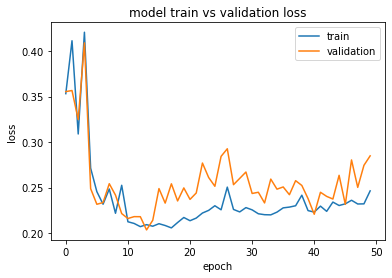

In [12]:
# plot train and validation loss
for i in range(args.client_num):
    exec("plt.plot(lloogg_"+str(i+1) + "['train']['epoch'], lloogg_"+str(i+1)+"['train']['loss'])")
    exec("plt.plot(lloogg_"+str(i+1) + "['val']['epoch'], lloogg_"+str(i+1) + "['val']['loss'])")
    exec("plt.title('model train vs validation loss')")
    exec("plt.ylabel('loss')")
    exec("plt.xlabel('epoch')")
    exec("plt.legend(['train', 'validation'], loc='upper right')")
    exec("plt.show()")

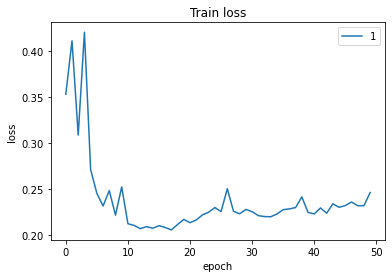

In [13]:
t = []
for i in range(args.client_num):
    exec("plt.plot(lloogg_"+str(i+1) + "['train']['epoch'], lloogg_"+str(i+1)+"['train']['loss'])")
    t.append(str(i+1))
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(t, loc='upper right')
plt.show()

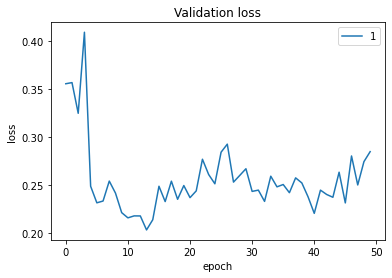

In [14]:
t = []
for i in range(args.client_num):
    exec("plt.plot(lloogg_"+str(i+1) + "['val']['epoch'], lloogg_"+str(i+1)+"['val']['loss'])")
    t.append(str(i+1))
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(t, loc='upper right')
plt.show()

In [15]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

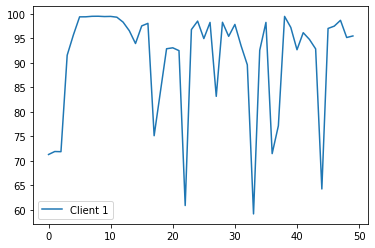

In [16]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

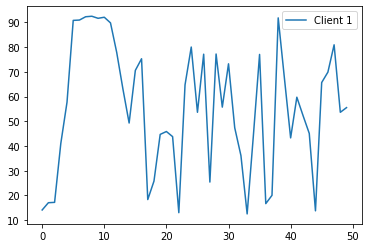

In [17]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()